# Выпускной проект

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.

## Описание услуг

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
    
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).
    
Файл `data_arc_new.csv`

- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

Файл `data_bulk_new.csv`

- `key` — номер партии;
- `Bulk 1`,..., `Bulk 15` — объём подаваемого материала.

Файл `data_bulk_time_new.csv`

- `key` — номер партии;
- `Bulk 1`, …, `Bulk 15` — время подачи материала.

Файл `data_gas_new.csv`

- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

Файл `data_temp_new.csv`

- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

Файл `data_wire_new.csv`

- `key` — номер партии;
- `Wire 1`, …, `Wire 9` — объём подаваемых проволочных материалов.

Файл `data_wire_time_new.csv`

- `key` — номер партии;
- `Wire 1`, …, `Wire 9` — время подачи проволочных материалов.



Объект моделирования - ковш

Цель: химсостав в регламенте

таргет - температура розлива

булки и вайры все разные (кодировки)

предположение 1

температура плавления (около 1400), все, что выше - лишнее (бурлит)
если не перегревать, то можно снизить потребление электричества (электроды)

предположение 2

огнеупорный кирпич (деньги на замену)
контроль перегрева - снизить кол-во ППР

длительность нагрева

последняя температура

суммарные примеси

полная мощность
vs
отношение мощностей



## Необходимые импорты

In [1]:
!pip install shap -q
!pip install phik -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import lightgbm as lgb

In [4]:
TEST_SIZE = .25
RANDOM_STATE = 30625
DEFAULT_COLOR = '#519872'
DATASET_FOLDER_PATH = '/datasets/'

In [5]:
sns.set_theme()

## Дополнительные функции

In [6]:
def analyze_residuals(residuals, predictions, model_string=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    if model_string is not None:
        axes[0].set_title(f'Гистограмма распределения остатков [{model_string}]')
    else:
        axes[0].set_title(f'Гистограмма распределения остатков')
        
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    axes[0].legend()
    
    
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].axhline(y=0, color='red', ls='--')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    if model_string is not None:
        axes[1].set_title(f'Анализ дисперсии [{model_string}]')
    else:
        axes[1].set_title(f'Анализ дисперсии')
    plt.show()

In [7]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel=''):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [8]:
def check_multicollinearity_vif(df):
    temp = (df
        .drop(columns=['id'], errors='ignore'))

    numeric_cols = (temp
                    .select_dtypes(['float64', 'int', 'int64'])
                    .columns)

    df = pd.DataFrame(temp[numeric_cols], 
                  columns=numeric_cols)

    X = add_constant(df)

    vif = pd.DataFrame(
    {
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }
    )
    return vif

# Загруза данных

## Датасет `data_arc_new.csv`

In [ ]:
try:
    data_arc_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_arc_new.csv', parse_dates=[1, 2])
except:
    data_arc_new = pd.read_csv('path', parse_dates=[1, 2])

In [10]:
data_arc_new.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [11]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


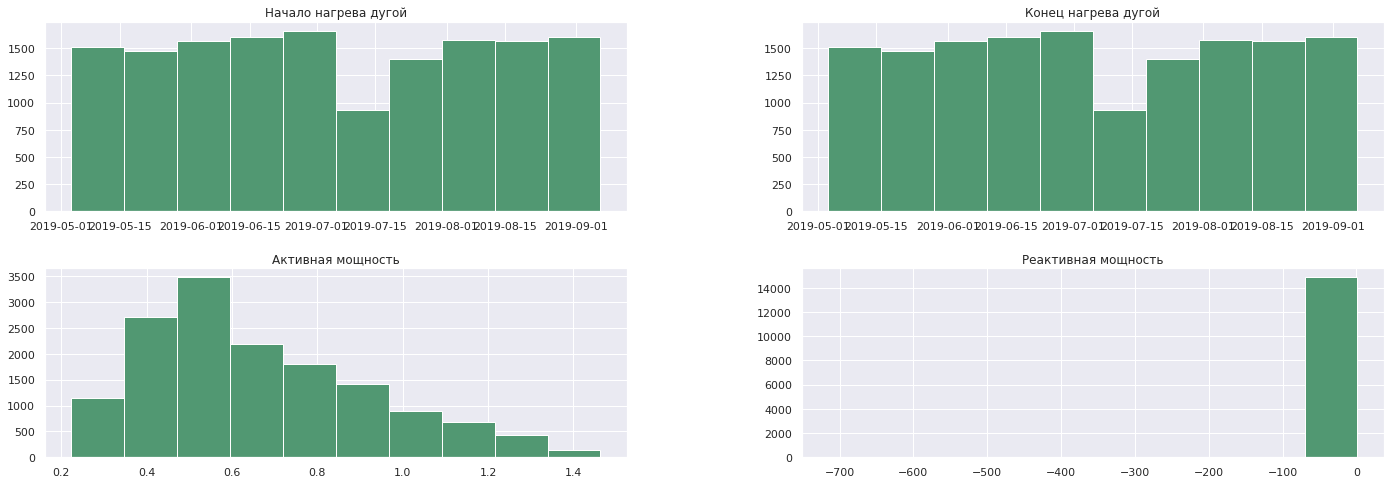

In [12]:
data_arc_new.drop(columns='key').hist(
    figsize=(24, 8), 
    color=DEFAULT_COLOR);

Отметим наличие выбросов в столбце с реактивной мощностью

### Явные дубликаты

In [13]:
data_arc_new.duplicated().sum()

0

### Пропуски в данных

In [14]:
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [15]:
data_arc_new.rename(columns=
    {
        'Начало нагрева дугой': 'arc_heating_start',
        'Конец нагрева дугой' : 'arc_heating_end',
        'Активная мощность'   : 'active_power',
        'Реактивная мощность' : 'reactive_power',
    },
    inplace=True
)

- Загрузили датасет data_arc_new
- Не нашли явных дубликатов
- Привели данные, касающиеся времени, к нужному формату
- Пропусков в данных не обнаружили

### Датасет `data_bulk_new.csv`

In [ ]:
try:
    data_bulk_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('path')

In [17]:
data_bulk_new.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


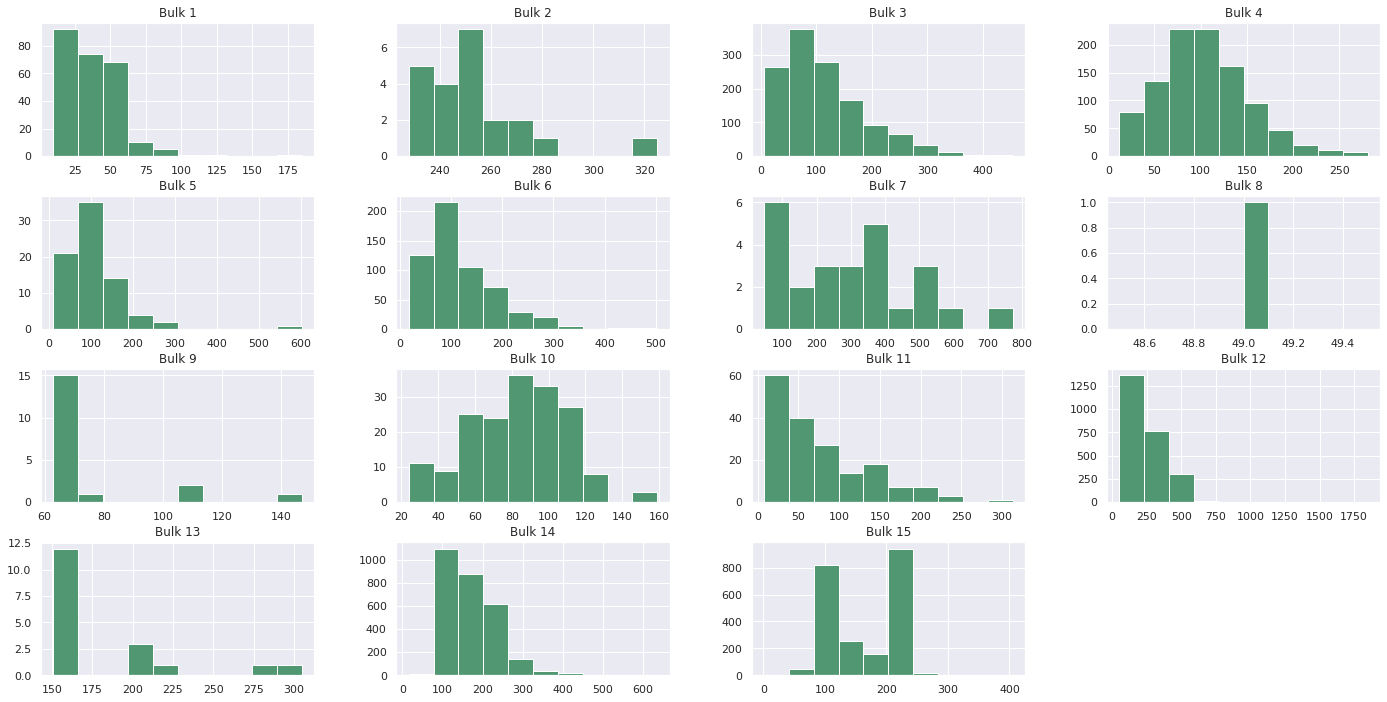

In [19]:
data_bulk_new.drop(columns='key').hist(
    figsize=(24, 12), 
    color=DEFAULT_COLOR);

#### Явные дубликаты

In [20]:
data_bulk_new.duplicated().sum()

0

#### Пропуски в данных

In [21]:
data_bulk_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [22]:
data_bulk_new.columns = data_bulk_new.columns.str.lower().str.split(' ').str.join('_')

In [23]:
data_bulk_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

- Загрузили датасет data_bulk_new
- Не нашли явных дубликатов
- Провели первичный визуальный анализ распределений столбцов датасета
- Пропусков в данных очень много, однако в данном случае это норма, будем позже заполнять их нулями

### Датасет `data_bulk_time_new.csv`

In [ ]:
try:
    data_bulk_time_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_bulk_time_new.csv', parse_dates=list(range(1,16)))
except:
    data_bulk_time_new = pd.read_csv('path', parse_dates=list(range(1,16)))

In [25]:
data_bulk_time_new.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [26]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


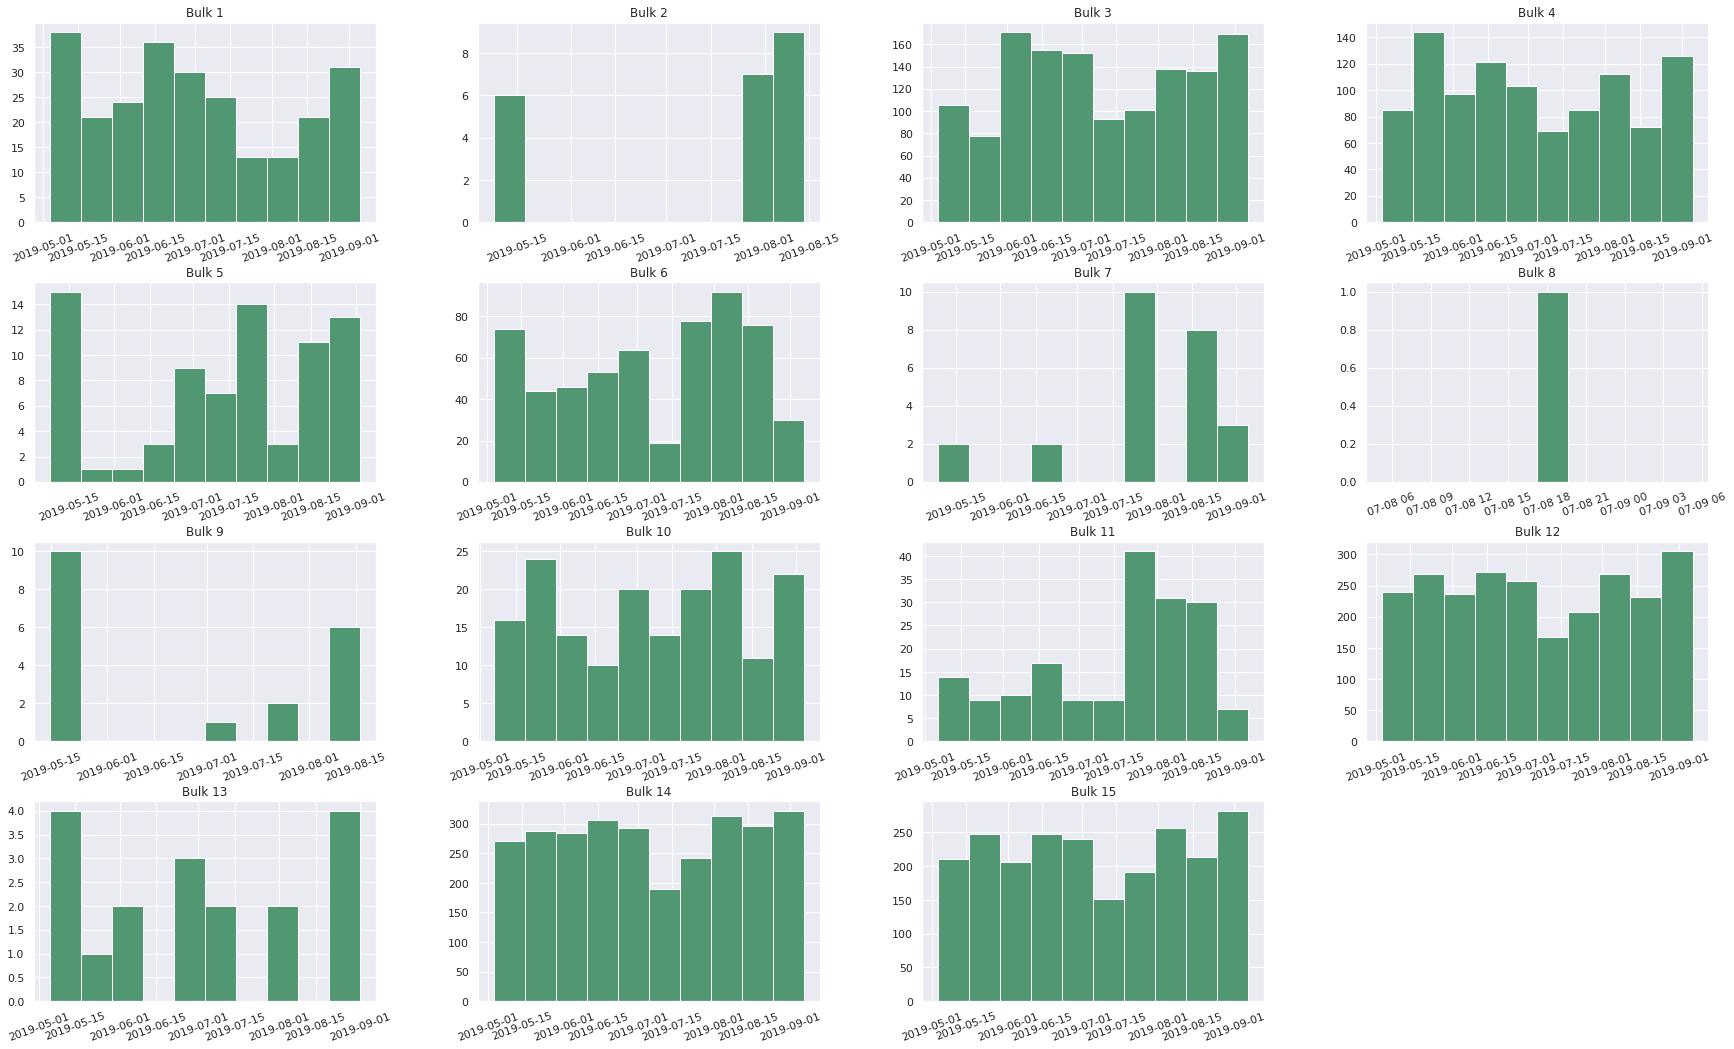

In [27]:
axes = data_bulk_time_new.drop(columns='key').hist(
    figsize=(30, 18), 
    color=DEFAULT_COLOR)

for ax in axes.flatten():
     ax.tick_params(rotation=20, axis='x')

#### Явные дубликаты

In [28]:
data_bulk_time_new.duplicated().sum()

0

#### Пропуски в данных

In [29]:
data_bulk_time_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [30]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.lower().str.split(' ').str.join('_')

In [31]:
cols = [data_bulk_time_new.columns[0]]
cols.extend(data_bulk_time_new.columns[1:] + '_time')
data_bulk_time_new.columns = cols

In [32]:
data_bulk_time_new.columns

Index(['key', 'bulk_1_time', 'bulk_2_time', 'bulk_3_time', 'bulk_4_time',
       'bulk_5_time', 'bulk_6_time', 'bulk_7_time', 'bulk_8_time',
       'bulk_9_time', 'bulk_10_time', 'bulk_11_time', 'bulk_12_time',
       'bulk_13_time', 'bulk_14_time', 'bulk_15_time'],
      dtype='object')

- Загрузили датасет data_bulk_time_new
- Не нашли явных дубликатов
- Привели столбцы-таймстампы к нужному формату
- Пропусков в данных очень много, однако в данном случае это норма, будем обрабатывать их позже

### Датасет `data_gas_new.csv`

In [ ]:
try:
    data_gas_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('path')

In [34]:
data_gas_new.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [35]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


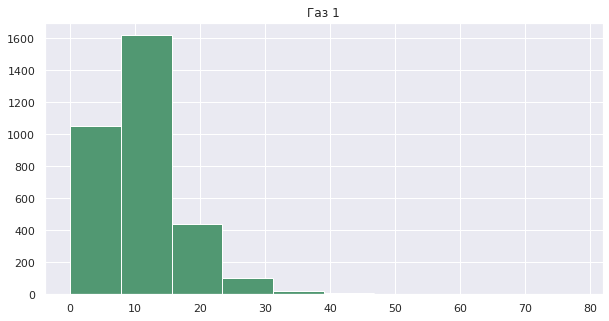

In [36]:
data_gas_new.drop(columns='key').hist(
    figsize=(10, 5), 
    color=DEFAULT_COLOR);

#### Явные дубликаты

In [37]:
data_gas_new.duplicated().sum()

0

#### Пропуски в данных

In [38]:
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

In [39]:
data_gas_new.rename(columns=
    {
        'Газ 1': 'gase_1'
    },
    inplace=True
)

- Загрузили датасет data_gas_new
- Провели экспресс-анализ столбцов датасета
- Переименовали столбцы

### Датасет `data_temp_new.csv`

In [ ]:
try:
    data_temp_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_temp_new.csv', parse_dates=[1])
except:
    data_temp_new = pd.read_csv('path', parse_dates=[1])

In [41]:
data_temp_new.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [42]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


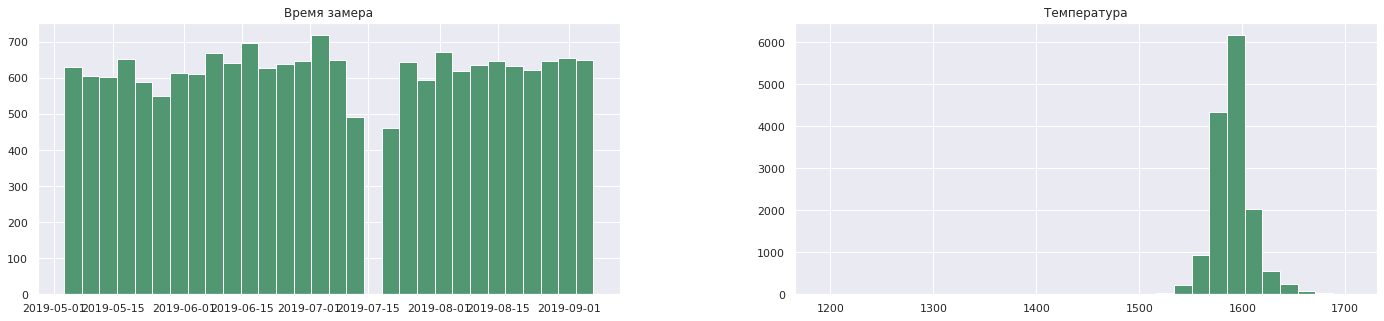

In [43]:
data_temp_new.drop(columns='key').hist(
    figsize=(24, 5), 
    color=DEFAULT_COLOR,
    bins=30
);

- На гистограмме температуры видны выбросы слева, нужно будет исследовать их дополнительно в разделе EDA

#### Явные дубликаты

In [44]:
data_temp_new.duplicated().sum()

0

#### Пропуски в данных

In [45]:
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [46]:
data_temp_new.rename(columns=
    {
        'Время замера': 'measure_time',
        'Температура': 'temperature'
    },
    inplace=True
)

- Загрузили датасет data_temp_new
- Провели первичный анализ данных: обнаружили выбросы в столбце temperature
- Пропуски в данных обнаружены
- Дубликатов явного типа не обнаружено

### Датасет `data_wire_new.csv`

In [ ]:
try:
    data_wire_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('path')

In [48]:
data_wire_new.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


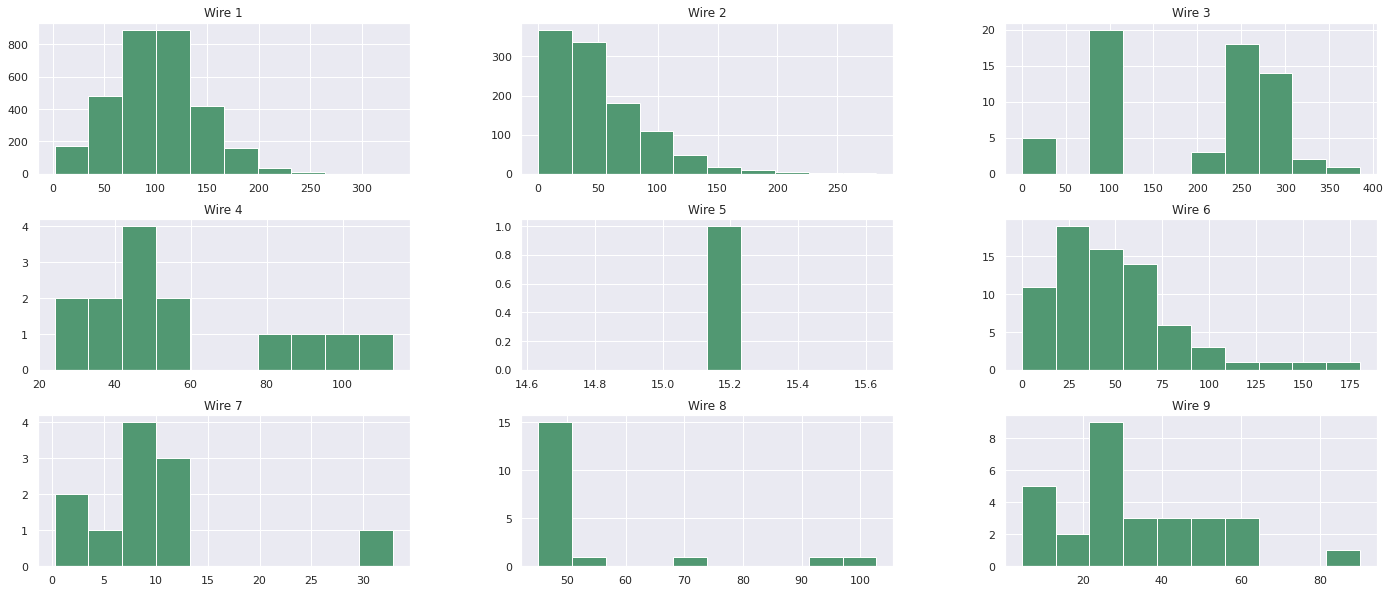

In [50]:
data_wire_new.drop(columns='key').hist(
    figsize=(24, 10), 
    color=DEFAULT_COLOR);

#### Явные дубликаты

In [51]:
data_wire_new.duplicated().sum()

0

#### Пропуски в данных

In [52]:
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [53]:
data_wire_new.columns = data_wire_new.columns.str.lower().str.split(' ').str.join('_')

In [54]:
data_wire_new.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

- Загрузили датасет data_wire_new
- Провели первичный анализ данных: обнаружили пропуски в столбцах, но это является нормой, будем заполнять их нулями
- Дубликатов явного типа не обнаружено

### Датасет `data_wire_time_new.csv`

In [ ]:
try:
    data_wire_time_new = pd.read_csv(DATASET_FOLDER_PATH + 'data_wire_time_new.csv', parse_dates=list(range(1,10)))
except:
    data_wire_time_new = pd.read_csv('path', parse_dates=list(range(1,10)))

In [56]:
data_wire_time_new.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [57]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


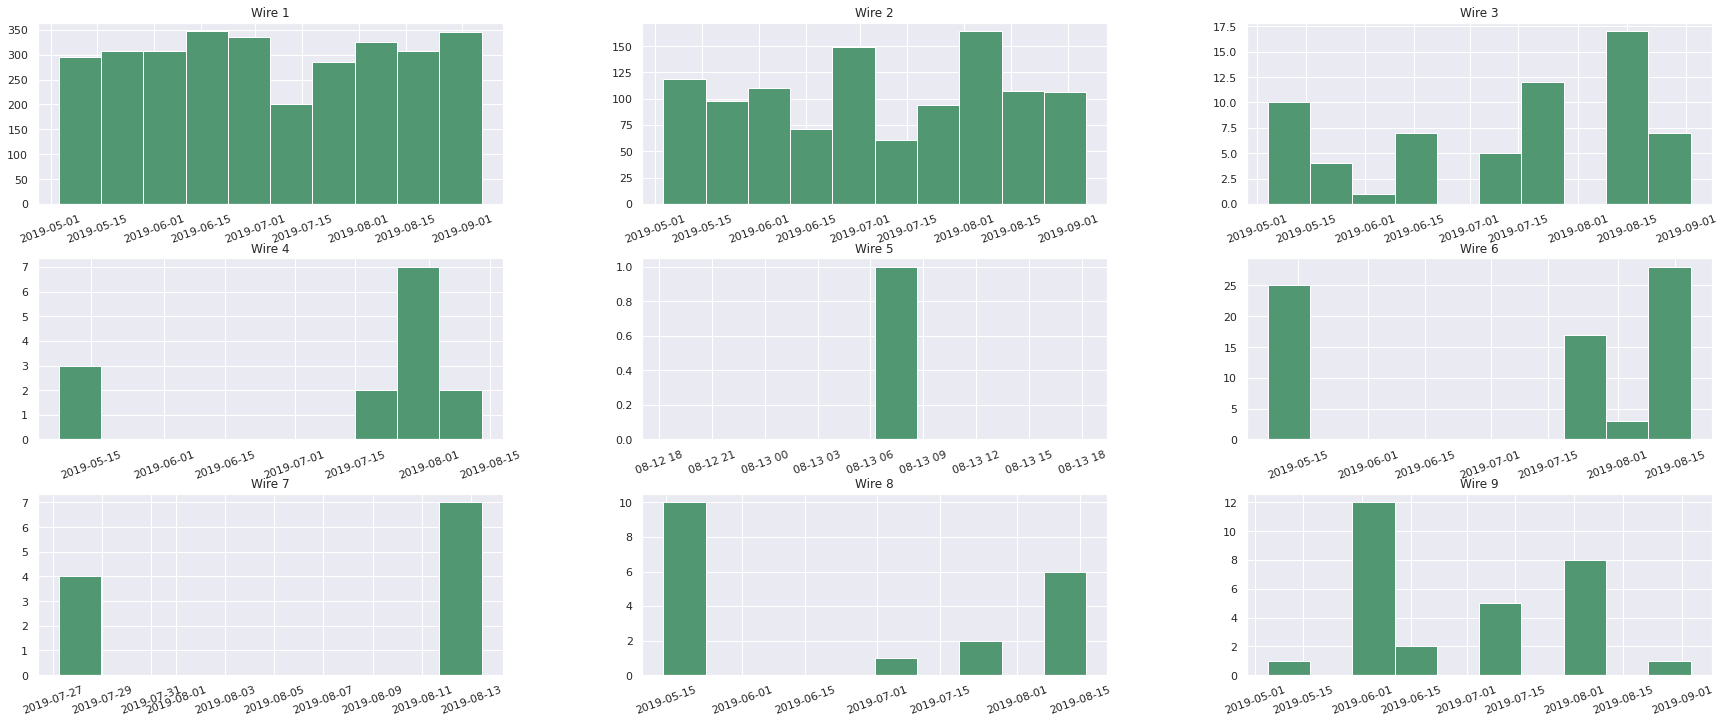

In [58]:
axes = data_wire_time_new.drop(columns='key').hist(
    figsize=(30, 12), 
    color=DEFAULT_COLOR)

for ax in axes.flatten():
     ax.tick_params(rotation=20, axis='x')

#### Явные дубликаты

In [59]:
data_wire_time_new.duplicated().sum()

0

#### Пропуски в данных

In [60]:
data_wire_time_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [61]:
data_wire_time_new.columns = data_wire_time_new.columns.str.lower().str.split(' ').str.join('_')

In [62]:
cols = [data_wire_time_new.columns[0]]
cols.extend(data_wire_time_new.columns[1:] + '_time')
data_wire_time_new.columns = cols

data_wire_time_new.columns

Index(['key', 'wire_1_time', 'wire_2_time', 'wire_3_time', 'wire_4_time',
       'wire_5_time', 'wire_6_time', 'wire_7_time', 'wire_8_time',
       'wire_9_time'],
      dtype='object')

- Загрузили датасет data_wire_time_new
- Провели первичный анализ данных: обнаружили пропуски в столбцах, их будем обрабатывать ниже
- Дубликатов явного типа не обнаружено

# Исследовательский анализ данных

## Датасет `data_arc_new.csv`

In [63]:
data_arc_new['arc_iters_count'] = data_arc_new.groupby('key')['arc_heating_start'].transform('count')

In [64]:
data_arc_new.describe()

,key,active_power,reactive_power,arc_iters_count
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986,5.187416
std,934.571502,0.258885,5.873485,1.749516
min,1.000000,0.223120,-715.479924,1.000000
25%,806.000000,0.467115,0.337175,4.000000
50%,1617.000000,0.599587,0.441639,5.000000
75%,2429.000000,0.830070,0.608201,6.000000
max,3241.000000,1.463773,1.270284,16.000000


Так как объект исследования - это ковш, нужно посмотреть, какое количество уникальных объектов есть в данных  

In [65]:
data_arc_new.key.nunique()

3214

In [66]:
data_arc_new['arc_heating_duration'] = (
    data_arc_new.arc_heating_end - data_arc_new.arc_heating_start
).dt.total_seconds()

Теперь построим распределение суммарного времени нагрева, проагрегированного по партии

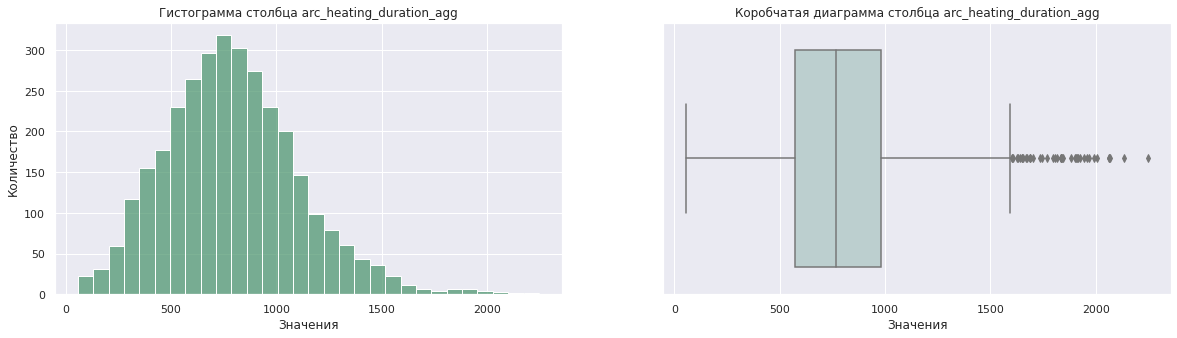

In [67]:
(plot_graphics(
    data_arc_new
    .groupby('key')[['arc_heating_duration']]
    .sum()
    .rename(
        columns={
            'arc_heating_duration': 'arc_heating_duration_agg'
        }).query('arc_heating_duration_agg < 2500'), 
    column_name='arc_heating_duration_agg'))

Распределение не совсем симметричное, есть выбросы слева

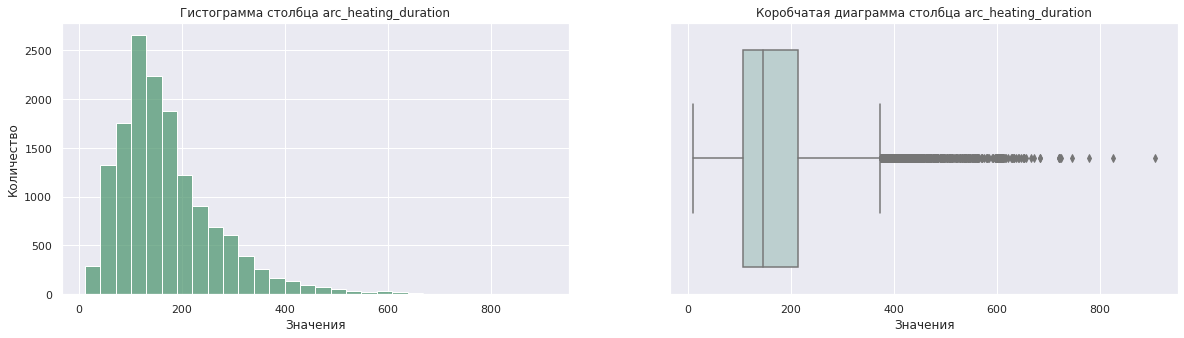

In [68]:
plot_graphics(data_arc_new, column_name='arc_heating_duration')

Посмотрим на распределение столбца reactive_power

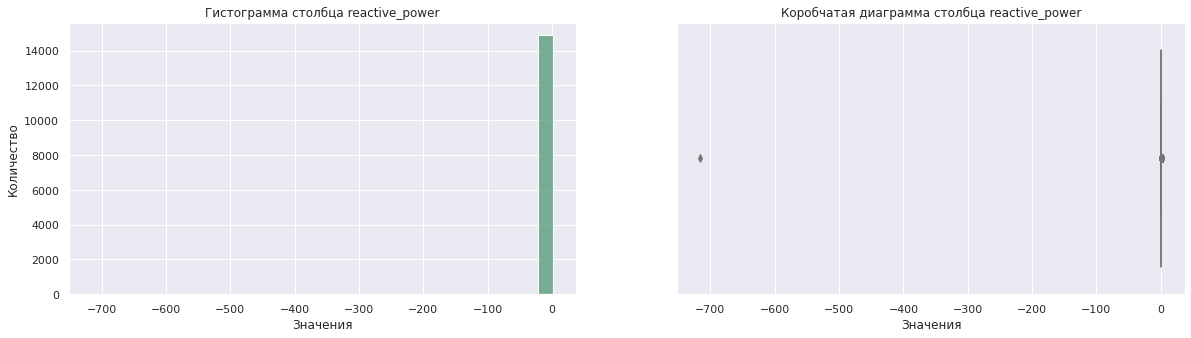

In [69]:
plot_graphics(data_arc_new, column_name='reactive_power')

Здесь присутствует супервыброс слева. Избавимся от всех партий, которые имеют реактивную мощность меньше -700

In [70]:
keys_outliers = data_arc_new.query('reactive_power < -700').key.unique()

In [71]:
data_arc_new = data_arc_new.query('key not in @keys_outliers')

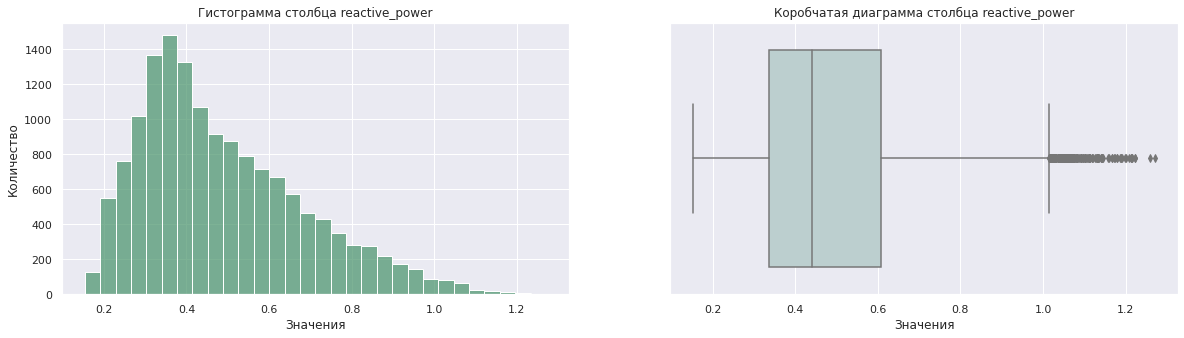

In [72]:
plot_graphics(data_arc_new, column_name='reactive_power')

Теперь распределение этого столбца выглядит приличнее. Аналогично посмотрим на распределение активной мощности

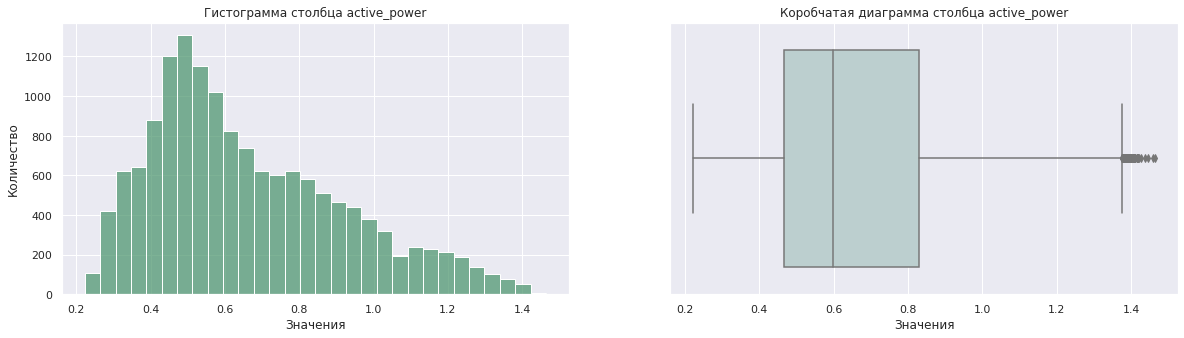

In [73]:
plot_graphics(data_arc_new, column_name='active_power')

Cгенерируем признак full_power, включающий активную и реактивную мощности

In [74]:
data_arc_new['full_power'] = (
    data_arc_new.active_power ** 2 + data_arc_new.reactive_power ** 2
) ** .5

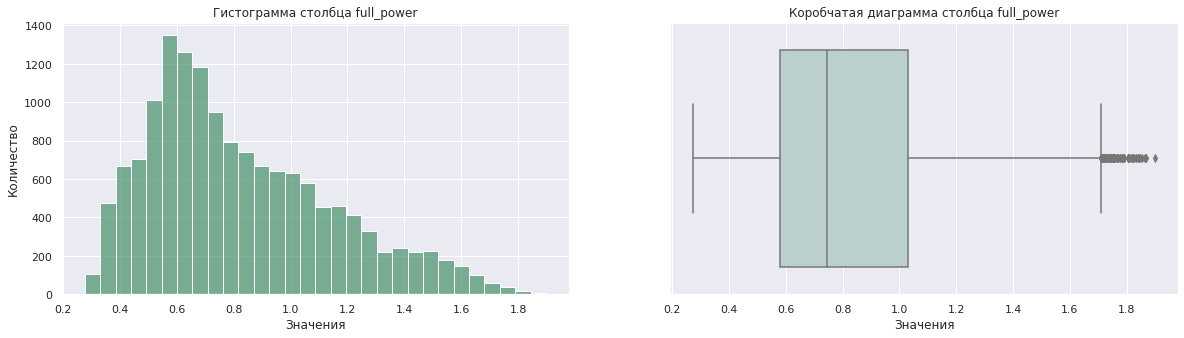

In [75]:
plot_graphics(data_arc_new, column_name='full_power')

Теперь посчитаем затраченную электроэнергию

In [76]:
data_arc_new['wasted_energy'] = data_arc_new['full_power'] * data_arc_new['arc_heating_duration']

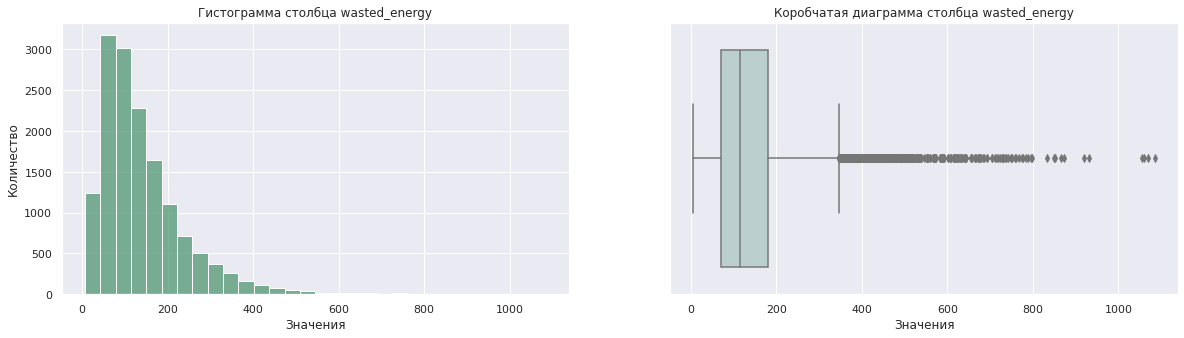

In [77]:
plot_graphics(data_arc_new, column_name='wasted_energy')

Видим длинный хвост справа, значит есть большие энергозатраты. Еще посчитаем коэффициент мощности

In [78]:
data_arc_new['power_coef'] = data_arc_new['active_power'] / data_arc_new['full_power']

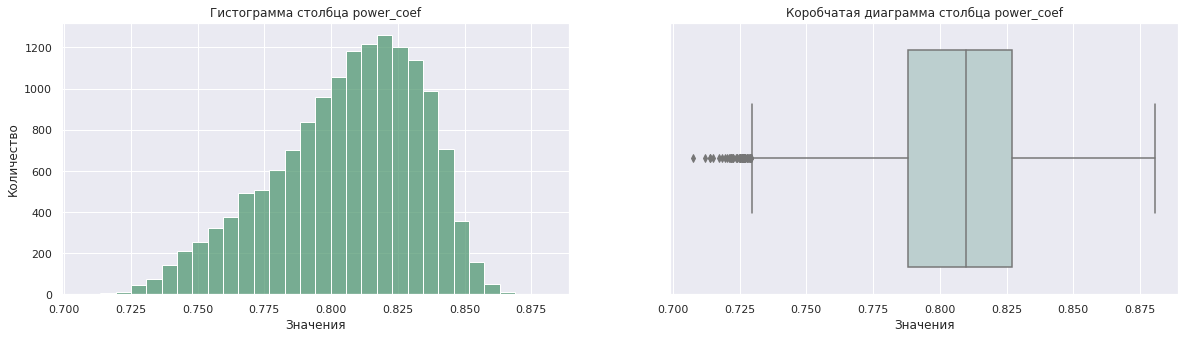

In [79]:
plot_graphics(data_arc_new, column_name='power_coef')

In [80]:
def categorize_full_power(x):
    if x <= data_arc_new.full_power.quantile(0.05):
        return 'очень низкая'
    elif data_arc_new.full_power.quantile(0.05) <= x <= data_arc_new.full_power.quantile(0.25):
        return 'низкая'
    elif data_arc_new.full_power.quantile(0.25) <= x <= data_arc_new.full_power.quantile(0.5):
        return 'средняя'
    elif data_arc_new.full_power.quantile(0.5) <= x <= data_arc_new.full_power.quantile(0.75):
        return 'выше среднего'
    elif data_arc_new.full_power.quantile(0.75) <= x <= data_arc_new.full_power.quantile(0.995):
        return 'высокая'
    elif data_arc_new.full_power.quantile(0.995) <= x:
        return 'очень высокая'

In [81]:
data_arc_new['cat_full_power'] = data_arc_new['full_power'].apply(lambda x: categorize_full_power(x))

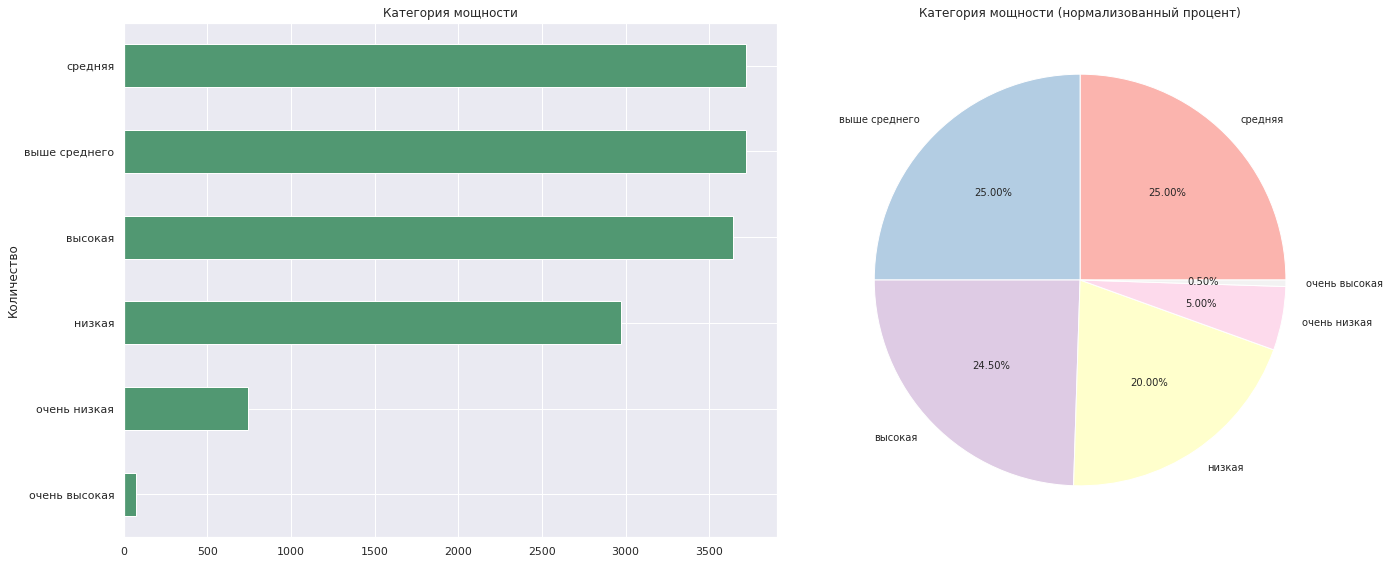

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

(data_arc_new
 .pivot_table(
     index='cat_full_power', 
     values='key', 
     aggfunc='count')
 .sort_values('key')
 .plot(
     kind='barh', 
     ylabel='Категория мощности', 
     xlabel='Количество',
     ax=ax[0],
     color=DEFAULT_COLOR,
     title='Категория мощности',
     legend=None));

(data_arc_new
 .cat_full_power
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.2f%%",
     ylabel="",
     title=f"Категория мощности (нормализованный процент)",
     colormap='Pastel1',
     ax=ax[1],
     fontsize=10));

fig.tight_layout()

- Исходя из категориального анализа заключаем, что большинство партий потребовали мощности выше средней
- Есть несколько партий, который потребовали очень высокого значения мощности

## Датасет `data_bulk_new.csv`

In [83]:
data_bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Здесь заполним пропуски нулём, так как пропуск в столбце обозначает нулевую добавку

In [84]:
data_bulk_new = data_bulk_new.fillna(0)

Теперь посмотрим, как часто используется конкретная bulk добавка

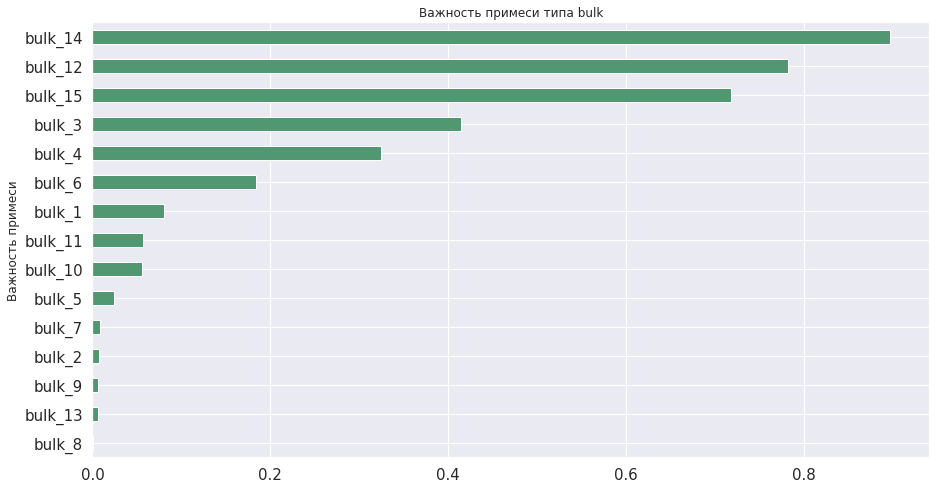

In [85]:
((data_bulk_new
  .iloc[:, 1:] > 0)
 .mean()
 .sort_values()
 .plot(
     kind='barh', 
     figsize=(15, 8), 
     color=DEFAULT_COLOR, 
     title='Важность примеси типа bulk', 
     xlabel='Важность примеси', 
     ylabel='Код примеси', fontsize=15));

- Самая частая добавка - bulk_14
- Самая редкая добавка - bulk_8

Вынося за скобки теплоемкость материалов, введем новый признак total_bulk - суммарная масса введенных добавок

In [86]:
data_bulk_new['total_bulk'] = data_bulk_new.loc[:, 'bulk_1':'bulk_15'].sum(axis=1)

In [87]:
non_important_bulks = [
    'bulk_4', 
    'bulk_6', 
    'bulk_1', 
    'bulk_11', 
    'bulk_10', 
    'bulk_5', 
    'bulk_7', 
    'bulk_2', 
    'bulk_9', 
    'bulk_13', 
    'bulk_8'
]

In [88]:
data_bulk_new['non_important_bulks'] = data_bulk_new[non_important_bulks].sum(axis=1)

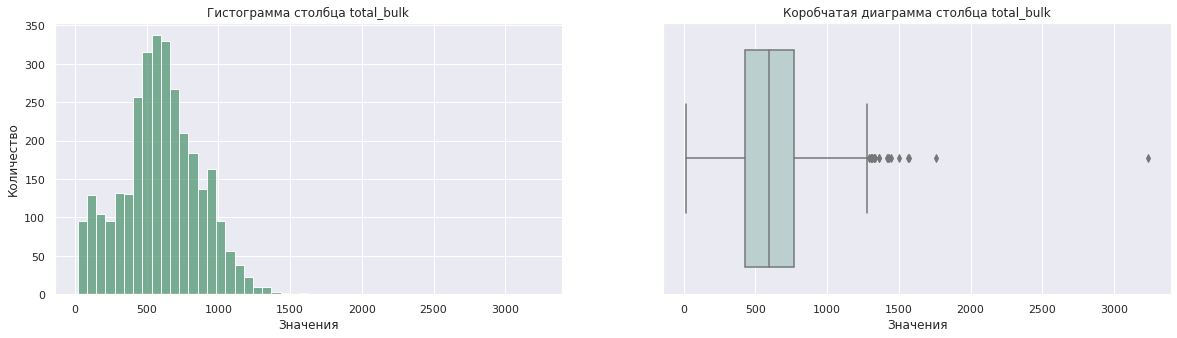

In [89]:
plot_graphics(data_bulk_new, 'total_bulk', bins=50)

- Видим сильный выброс справа. Возможно, это ошибка в данных

## Датасет `data_bulk_time_new.csv`

In [90]:
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Сгенерируем два новых признака 
- time_range_bulk: суммарное время, за которое в партии были добавлены bulk примеси
- time_diffs_mean_bulk: среднее время внутри партии между добавками

In [91]:
for idx, row in data_bulk_time_new[[f'bulk_{i}_time' for i in range(1, 16)]].iterrows():
    s = pd.Series(sorted([x for x in row.values if pd.notna(x)]))
    
    data_bulk_time_new.at[idx, 'time_range_bulk'] = (s.max() - s.min()).total_seconds()
    data_bulk_time_new.at[idx, 'time_diffs_mean_bulk'] = s.diff().mean().total_seconds()

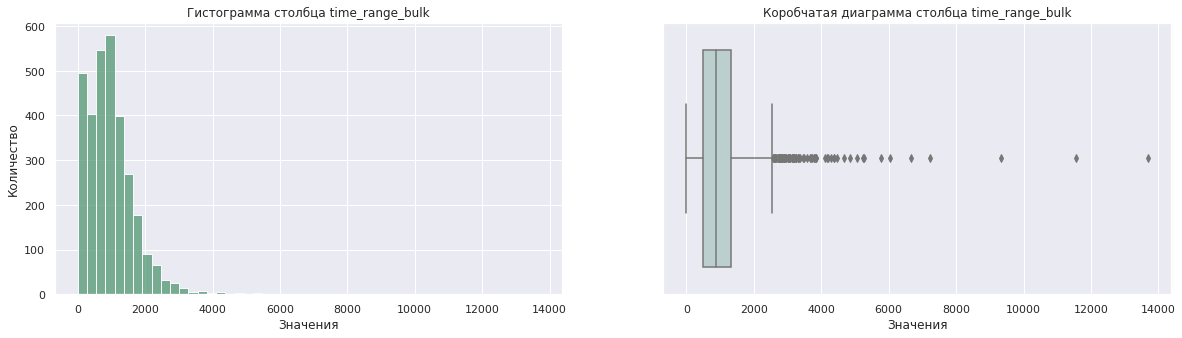

In [92]:
plot_graphics(data_bulk_time_new, 'time_range_bulk', bins=50)

Есть очень сильный выбросы справа. Вряд ли обработка одной партии может длиться так долго. Скорее всего это ошибочные данные

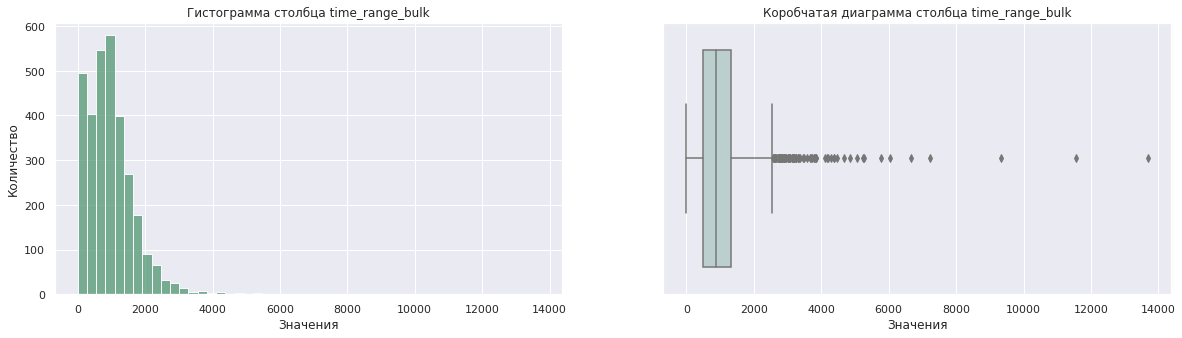

In [93]:
plot_graphics(data_bulk_time_new, 'time_range_bulk', bins=50)

In [94]:
data_bulk_time_new['time_diffs_mean_bulk'] = data_bulk_time_new['time_diffs_mean_bulk'].fillna(0)

Посмотрим на 0.997 квантиль

In [95]:
data_bulk_time_new['time_diffs_mean_bulk'].quantile(0.997)

1510.54

- Эти данные, скорее всего, помехи

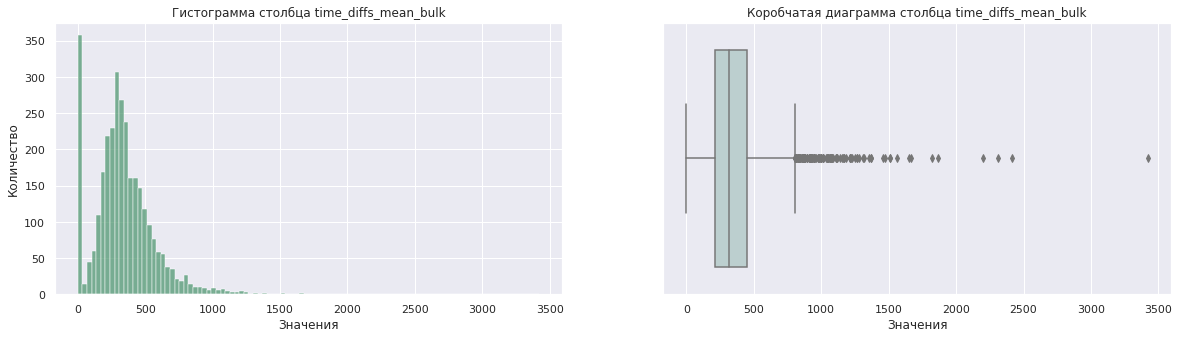

In [96]:
plot_graphics(data_bulk_time_new, 'time_diffs_mean_bulk', bins=100)

In [97]:
data_bulk_time_new[['time_range_bulk', 'time_diffs_mean_bulk']].astype('float64').describe()

,time_range_bulk,time_diffs_mean_bulk
count,3129.000000,3129.000000
mean,964.906679,341.701406
std,798.088025,242.921614
min,0.000000,0.000000
25%,485.000000,209.000000
50%,877.000000,313.000000
75%,1311.000000,446.000000
max,13683.000000,3420.750000


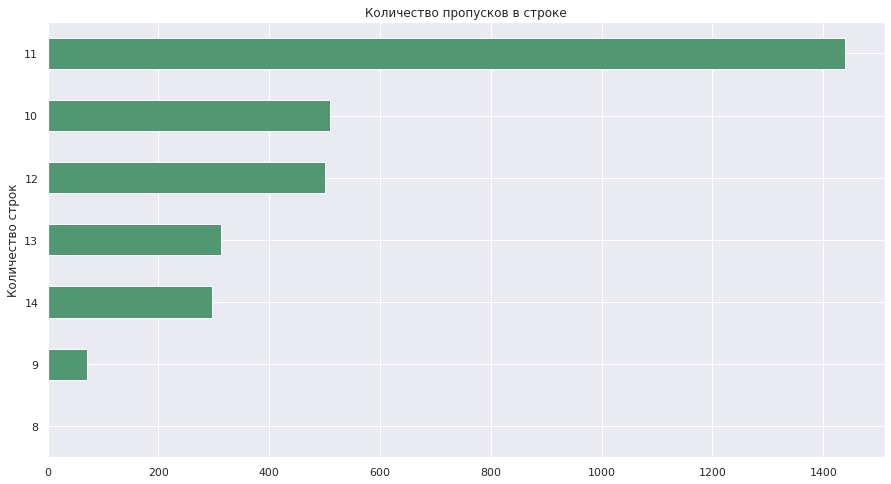

In [98]:
(pd.Series(data_bulk_time_new[[f'bulk_{i}_time' for i in range(1, 16)]]
           .isna()
           .sum(axis=1)
           .values)
 .value_counts()
 .sort_values()
 .plot(kind='barh', 
       figsize=(15, 8), 
       title='Количество пропусков в строке', 
       xlabel='Количество строк', 
       ylabel='Количество пропусков', 
       color=DEFAULT_COLOR));

- Чаще всего добавляют 5 примесей
- Реже - 7 

## Датасет `data_gas_new.csv`

In [99]:
data_gas_new.describe()

,key,gase_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


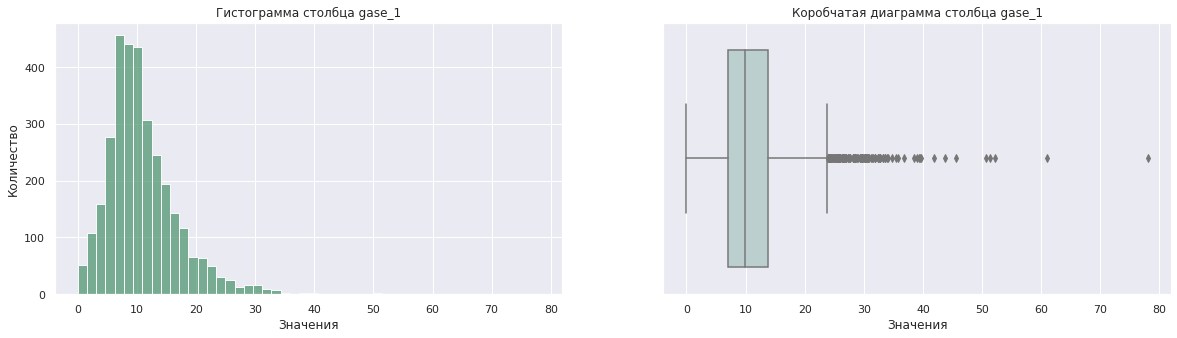

In [100]:
plot_graphics(data_gas_new, 'gase_1', bins=50)

## Датасет `data_temp_new.csv`

In [101]:
data_temp_new.describe()

,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


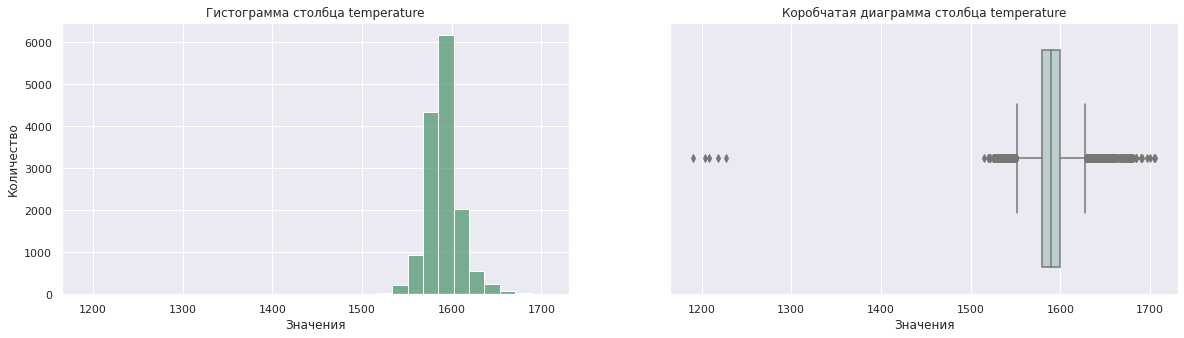

In [102]:
plot_graphics(data_temp_new, 'temperature')

- Видим выбросы слева. Ограничим температуру минимально необходимой для плавления.

In [103]:
outliers_keys = data_temp_new.query('temperature < 1400').key.unique()
data_temp_new = data_temp_new.query('key not in @outliers_keys')

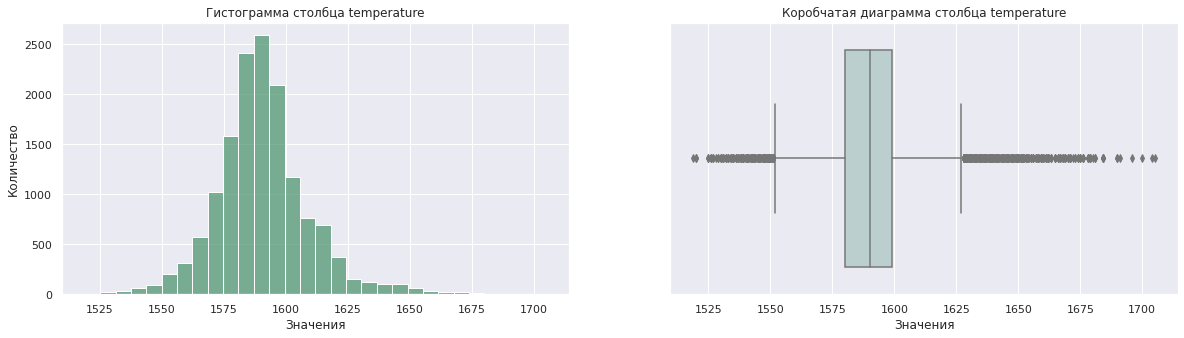

In [104]:
plot_graphics(data_temp_new, 'temperature')

In [105]:
unique_keys = data_temp_new.key.unique()
measure_deltas = []
temp_deltas = []

for k in unique_keys:
    measure_deltas.append(
        data_temp_new
        .query('key == @k')
        .measure_time
        .sort_values()
        .diff()
        .mean()
        .total_seconds())
    
    temp_deltas.append(
        data_temp_new
        .loc[data_temp_new
             .query('key == @k')
             .measure_time
             .sort_values()
             .index, 'temperature']
        .diff()
        .mean())

In [106]:
pd.Series(measure_deltas).describe()

count    3209.000000
mean      513.498923
std       389.609365
min       169.500000
25%       361.500000
50%       438.000000
75%       555.000000
max      8390.000000
dtype: float64

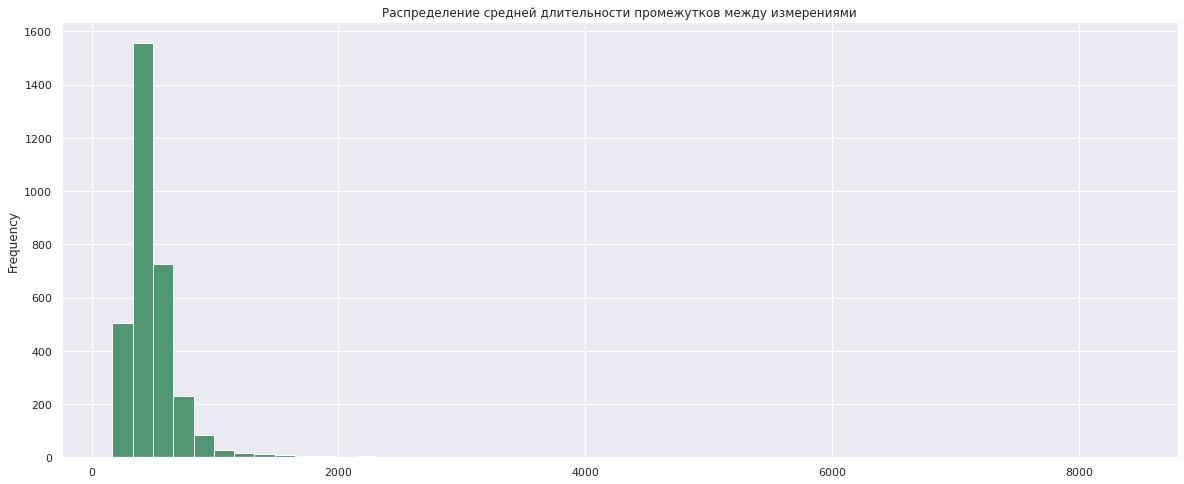

In [107]:
(pd.Series(measure_deltas)
 .plot(
     kind='hist', 
     bins=50, 
     figsize=(20, 8), 
     title='Распределение средней длительности промежутков между измерениями', 
     xlabel='Количество секунд', 
     ylabel='Количество', 
     color=DEFAULT_COLOR));

- В среднем измерения происходят внутри партии раз в 513 секунд

In [108]:
pd.Series(temp_deltas).describe()

count    2471.000000
mean        0.684221
std         6.667206
min       -70.000000
25%        -1.875000
50%         1.500000
75%         4.666667
max        21.000000
dtype: float64

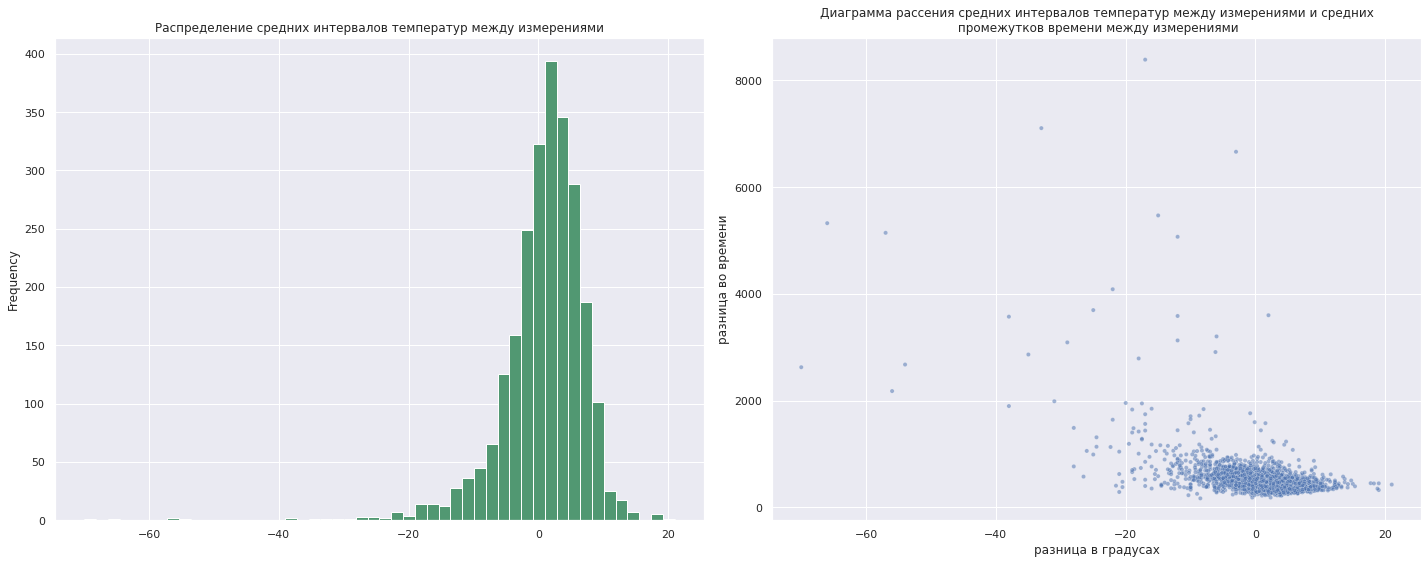

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

(pd.Series(temp_deltas)
 .plot(
     kind='hist', 
     bins=50, 
     ax=ax[0], 
     title='Распределение средних интервалов температур между измерениями', 
     xlabel='разница в градусах', 
     ylabel='Количество', 
     color=DEFAULT_COLOR));

ax[1].set_title('Диаграмма рассения средних интервалов температур между измерениями и средних\n промежутков времени между измерениями')
ax[1].set_xlabel('разница в градусах')
ax[1].set_ylabel('разница во времени')
sns.scatterplot(x=temp_deltas, 
                y=measure_deltas, 
                markers='o', 
                alpha=0.5, 
                size=20, 
                legend=None);

fig.tight_layout()

Что касается разницы в температурах при измерениях внутри партии, медианное значение разницы составляет примерно 1.5 градуса

## Датасет `data_wire_new.csv`

In [110]:
data_wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Здесь заполним пропуски нулём, так как пропуск в столбце обозначает нулевую добавку

In [111]:
data_wire_new = data_wire_new.fillna(0)

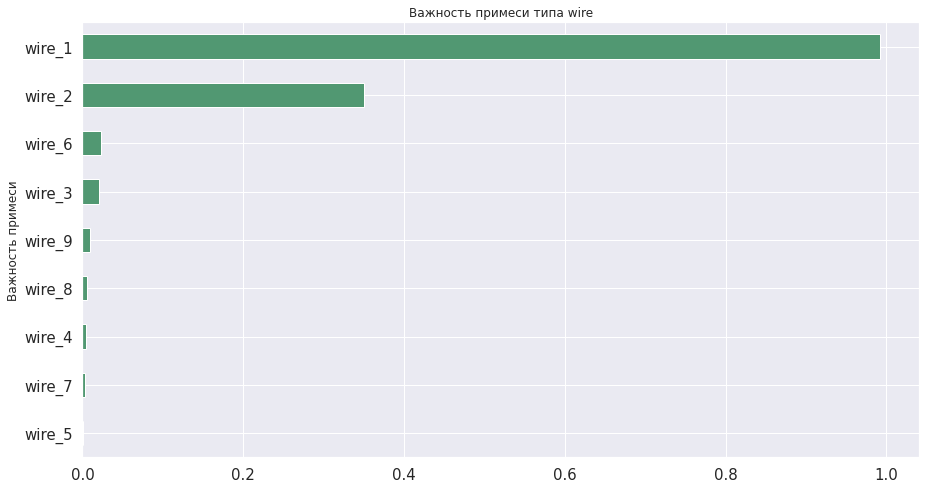

In [112]:
((data_wire_new
  .iloc[:, 1:] > 0)
 .mean()
 .sort_values()
 .plot(
     kind='barh', 
     figsize=(15, 8), 
     color=DEFAULT_COLOR, 
     title='Важность примеси типа wire', 
     xlabel='Важность примеси', 
     ylabel='Код примеси', fontsize=15));

- Самая частая добавка - wire_1
- Самая редкая добавка - wire_5

Вынося за скобки теплоемкость материалов, введем новый признак total_wire - суммарная масса введенных добавок

In [113]:
non_important_wire = ['wire_6', 'wire_3', 'wire_9', 'wire_8', 'wire_4', 'wire_7', 'wire_5',]

In [114]:
data_wire_new['non_important_wire'] = data_wire_new[non_important_wire].sum(axis=1)

In [115]:
data_wire_new['total_wire'] = data_wire_new.loc[:, 'wire_1':'wire_9'].sum(axis=1)

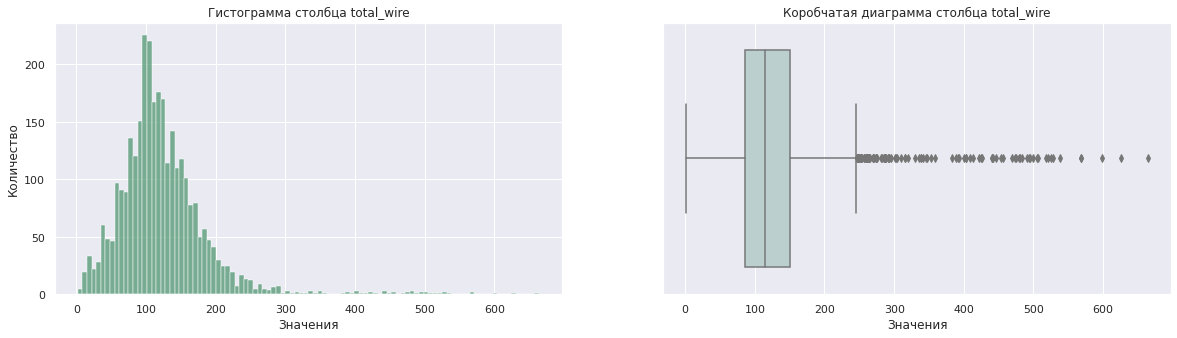

In [116]:
plot_graphics(data_wire_new, 'total_wire', bins=100)

- Справа есть увесистый хвост с выбросами, но их относительная непрерывность указывает на то, что такое в целом возможно

## Датасет `data_wire_time_new.csv`

In [117]:
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Сгенерируем два новых признака

- time_range_wire: суммарное время, за которое в партии были добавлены wire примеси
- time_diffs_mean_wire: среднее время внутри партии между добавками wire

In [118]:
for idx, row in data_wire_time_new[[f'wire_{i}_time' for i in range(1, 10)]].iterrows():
    s = pd.Series(sorted([x for x in row.values if pd.notna(x)]))
    
    data_wire_time_new.at[idx, 'time_range_wire'] = (s.max() - s.min()).total_seconds()
    data_wire_time_new.at[idx, 'time_diffs_mean_wire'] = s.diff().mean().total_seconds()

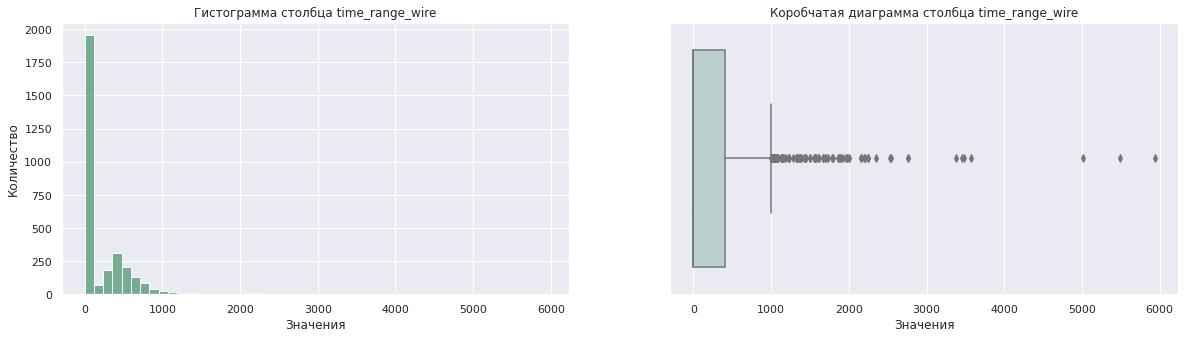

In [119]:
plot_graphics(data_wire_time_new, 'time_range_wire', bins=50)

- Есть три очень подозрительных промежутка, которые сильно отличаются от основной части. Вероятнее всего это ошибки в данных

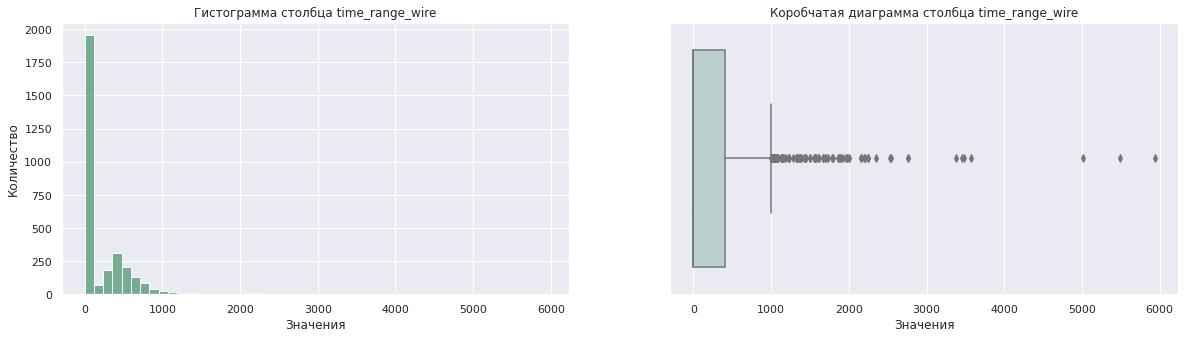

In [120]:
plot_graphics(data_wire_time_new, 'time_range_wire', bins=50)

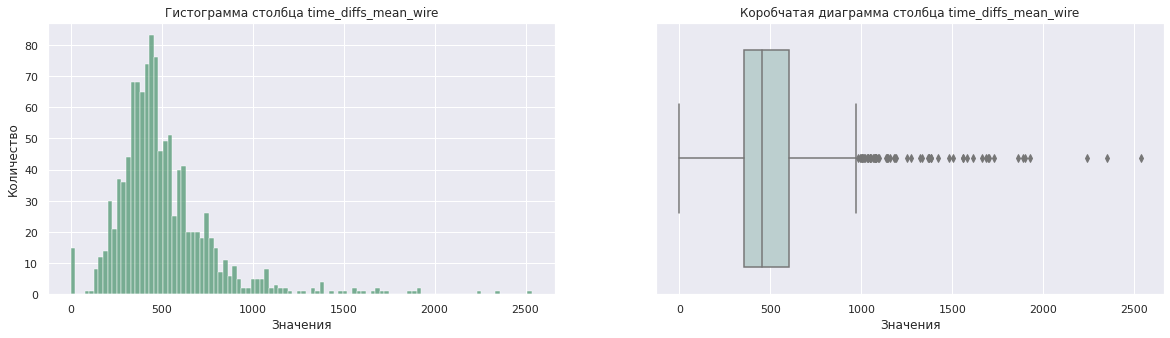

In [121]:
plot_graphics(data_wire_time_new, 'time_diffs_mean_wire', bins=100)

In [122]:
data_wire_time_new['time_diffs_mean_wire'] = data_wire_time_new['time_diffs_mean_wire'].fillna(0)

Посмотрим на 0.995 квантиль

In [123]:
data_wire_time_new['time_diffs_mean_wire'].quantile(0.995)

1536.399999999995

- Скорее всего тут есть ошибки в данных, так как большая часть значений в столбце time_diffs_mean_wire лежит в диапазоне до 1536 секунд

In [124]:
data_wire_time_new[['time_range_wire', 'time_diffs_mean_wire']].astype('float64').describe()

,time_range_wire,time_diffs_mean_wire
count,3081.000000,3081.000000
mean,214.519312,189.964595
std,396.131967,298.111108
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,401.000000,386.000000
max,5937.000000,2535.000000


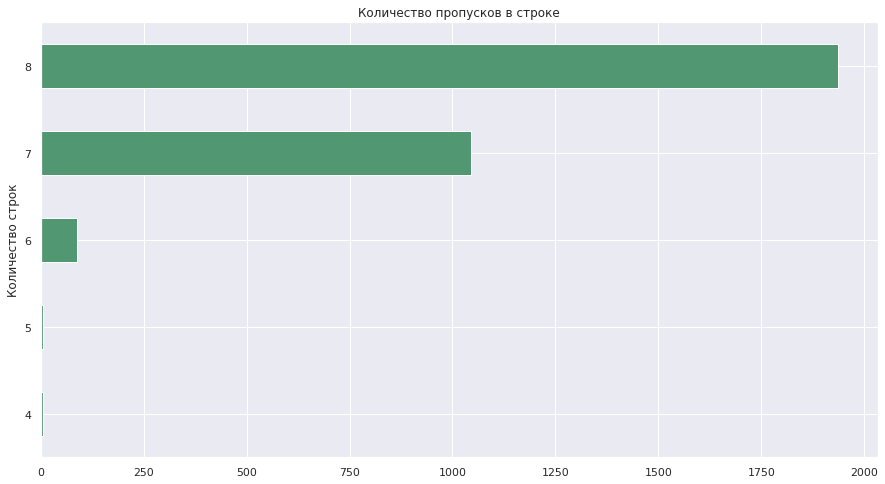

In [125]:
(pd.Series(data_wire_time_new[[f'wire_{i}_time' for i in range(1, 10)]]
           .isna()
           .sum(axis=1)
           .values)
 .value_counts()
 .sort_values()
 .plot(kind='barh', 
       figsize=(15, 8), 
       title='Количество пропусков в строке', 
       xlabel='Количество строк', 
       ylabel='Количество пропусков', 
       color=DEFAULT_COLOR));

- Чаще всего добавляют 1 примесь
- Реже всего - 4-5 примесей

- В ходе EDA были подробно изучены все столбцы датасетов
- Были сгенерированы новые признаки:
    - Полная мощность
    - Коэффициент мощности
    - Длительность нагрева
    - Количество итераций нагрева
    - Суммарное время, за которое были добавлены все примеси и среднее время между итерациями добавки примесей
    - Суммарные примеси двух типов
- Часть данных были урезаны, так как представляли собой сильные выбросы. Отсечение производилось на основе квантилей и визуального анализа
- Было выяснено среднее количество добавок примесей, самые часто используемые из них и самые редкие.
- Затем самые редкие были собраны в единый признак
- Таргет-переменная была очищена от подозрительных выбросов. Согласно ТЗ был выбран диапазон температур плавления стали, все остальное было убрано.
- Было замечено, что нет партии, в которую не добавлялась хотя бы одна примесь любого типа.

# Объединение данных

Сначала отберем те партии, где было более двух измерений температуры

In [126]:
more_than_one_measurement_keys = (data_temp_new
                                  .groupby('key')['temperature']
                                  .transform(lambda x: x.count() >= 2))

Теперь из исходного датасета data_temp_new отбросим пропуски

In [127]:
data = data_temp_new[data_temp_new.temperature.notna()]

In [128]:
data.head()

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


А теперь выберем только те партии, где не менее двух измерений

In [129]:
data = data[data.key.isin(data[more_than_one_measurement_keys].key.unique())]

/tmp/ipykernel_31/411817960.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.key.isin(data[more_than_one_measurement_keys].key.unique())]


Проагрегируем по номеру партии датасет data_temp_new_agg

In [130]:
data_temp_new_agg = data.groupby('key')[['temperature', 'measure_time']].agg(
    
    start_measure_time=('measure_time', 'first'),
    end_measure_time=('measure_time', 'last'),
    temperature=('temperature', 'last'),
    initial_temperature=('temperature', 'first'),
).reset_index()

In [131]:
df = data_temp_new_agg

Далее необходимо сгруппировать по партиям датасет data_arc_new_agg. 
В нем выделим следующие признаки:
- total_duration_arc - суммарная длительность нагрева партии
- total_duration_arc_mean - средняя длительность нагрева партии
- full_power_mean - средняя мощность
- power_coef_mean - средний коэффициент мощности
- wasted_energy_sum - суммарная затраченная энергия
- wasted_energy_mean - средняя затраченная энергия

In [132]:
data_arc_new_agg = data_arc_new.groupby('key')[['arc_heating_duration', 'full_power', 'wasted_energy', 'power_coef']].agg(
    
    total_duration_arc=('arc_heating_duration', 'sum'),
    total_duration_arc_mean=('arc_heating_duration', 'mean'),
    full_power_mean=('full_power', 'mean'),
    power_coef_mean=('power_coef', 'mean'),
    wasted_energy_sum=('wasted_energy', 'sum'),
    wasted_energy_mean=('wasted_energy', 'mean'),
    
).reset_index()

In [133]:
dfs = [
    data_arc_new_agg, 
    data_bulk_new, 
    data_bulk_time_new, 
    data_gas_new, 
    data_wire_new, 
    data_wire_time_new
]

Выполним соединение датасетов

In [134]:
for d in dfs:
    df = df.merge(d, how='inner', on='key')

Удалим столбцы-таймстампы, а также редко встречающиеся bulks и wires

In [135]:
df = df.drop(
    columns=[f'wire_{i}_time' for i in range(1, 10)] +
            [f'bulk_{i}_time' for i in range(1, 16)] + ['measure_time'] + 
    non_important_bulks+non_important_wire,
    errors='ignore')

Также удалим вспомогательные признаки, которые недоступны при моделировании

In [136]:
forbidden_cols =  ['time_range_wire',
 'time_range_bulk',
 'time_diffs_mean_wire', 'time_diffs_mean_bulk']

In [137]:
df = df.drop(columns=forbidden_cols, errors='ignore')

- Получен рабочий объединенный датасет, пригодный для работы и выделению признаков
- Удалены вспомогательные признаки
- Удалены признаки-таймстампы

# Корреляционный анализ

Выполним корреляционный анализ

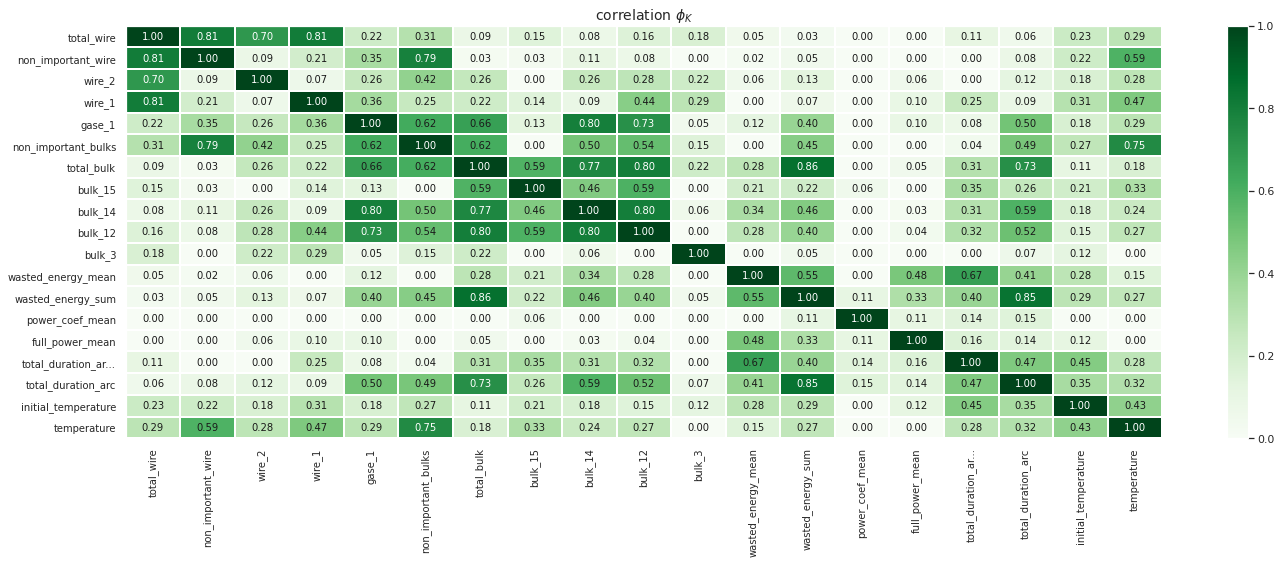

In [138]:
phik_overview = (df
                 .drop(columns=['key', 
                                'start_measure_time', 
                                'end_measure_time'])
                 .phik_matrix(interval_cols=df.drop(columns=['key', 
                                                             'start_measure_time', 
                                                             'end_measure_time']).columns))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(20, 8)
) 

- Видим очевидную связь между признаками, например, bulk_i и total_bulk, а также wire_i и total_wire. Фактически, это линейные комбинации
- Аналогично можно описать связь между total_duration_arc и wasted_energy_sum

In [139]:
corr_ph = (phik_overview[['temperature']]
           .drop(index='key', errors='ignore')
           .sort_values(by='temperature', ascending=False)[1:])
corr_ph

,temperature
non_important_bulks,0.750617
non_important_wire,0.592039
wire_1,0.470749
initial_temperature,0.425262
bulk_15,0.328520
total_duration_arc,0.317537
gase_1,0.290798
total_wire,0.287999
wire_2,0.282877
total_duration_arc_mean,0.280089


- Что касается таргет-переменной, то phik корреляция не выявила никакой взаимосвязи между таргетом и bulk_3 и power_coef_mean
- Очень низкая взаимосвязь с признаком gase_1
- Наиболее высокой взаимосвязью с таргетом обладают признаки wire_1, non_important_wire,non_important_bulks, initial_temperature, total_duration_arc

In [140]:
fields = list(corr_ph[abs(corr_ph) >= 0.2].dropna().index)
fields

['non_important_bulks',
 'non_important_wire',
 'wire_1',
 'initial_temperature',
 'bulk_15',
 'total_duration_arc',
 'gase_1',
 'total_wire',
 'wire_2',
 'total_duration_arc_mean',
 'bulk_12',
 'wasted_energy_sum',
 'bulk_14']

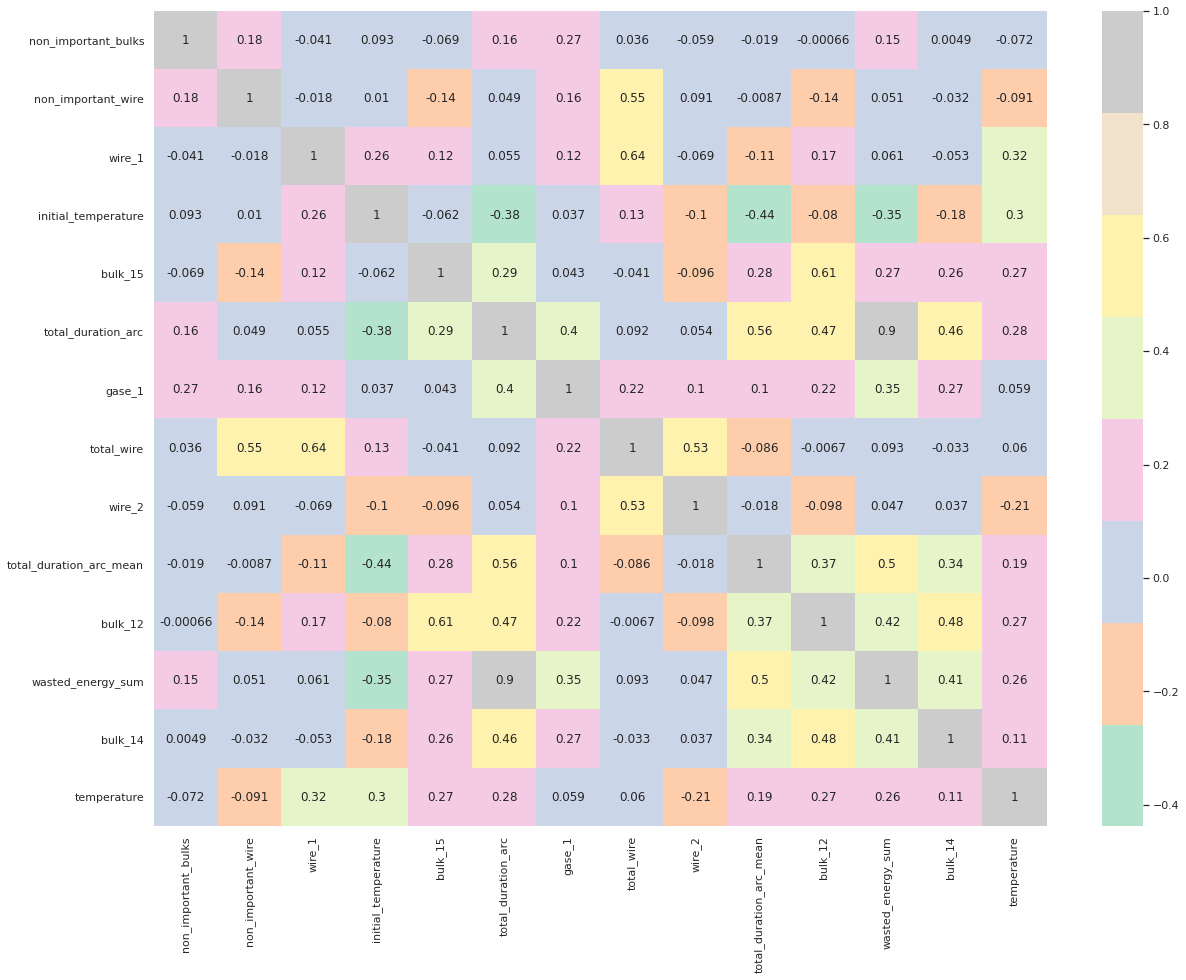

In [141]:
plt.figure(figsize=(20, 15))
sns.heatmap(df[fields+['temperature']].corr(), annot=True, cmap='Pastel2');

- Ярко выраженной мультиколлинеарности не наблюдается

- Здесь была проверена phik корреляция между признаками в объединенном датасете
- Получены наборы признаков, имеющие наибольшее влияние на таргет переменную
- Проведена проверка на мультиколлинеарность

In [143]:
df[fields]

,non_important_bulks,non_important_wire,wire_1,initial_temperature,bulk_15,total_duration_arc,gase_1,total_wire,wire_2,total_duration_arc_mean,bulk_12,wasted_energy_sum,bulk_14
0,43.0,0.0,60.059998,1571.0,154.0,1098.0,29.749986,60.059998,0.00000,219.600000,206.0,770.282114,150.0
1,73.0,0.0,96.052315,1581.0,154.0,811.0,12.555561,96.052315,0.00000,202.750000,206.0,481.760005,149.0
2,34.0,0.0,91.160157,1596.0,153.0,655.0,28.554793,91.160157,0.00000,131.000000,205.0,722.837668,152.0
3,81.0,0.0,89.063515,1601.0,154.0,741.0,18.841219,89.063515,0.00000,185.250000,207.0,683.455597,153.0
4,78.0,0.0,89.238236,1576.0,152.0,869.0,5.413692,98.352796,9.11456,217.250000,203.0,512.169934,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,90.0,0.0,89.150879,1570.0,223.0,723.0,7.125735,89.150879,0.00000,180.750000,256.0,694.177326,129.0
2320,185.0,0.0,114.179527,1554.0,226.0,940.0,9.412616,114.179527,0.00000,156.666667,256.0,815.818538,129.0
2321,85.0,0.0,94.086723,1571.0,226.0,569.0,6.271699,103.134723,9.04800,189.666667,230.0,823.020520,124.0
2322,101.0,0.0,118.110717,1591.0,207.0,750.0,14.953657,118.110717,0.00000,150.000000,206.0,581.810739,129.0


In [140]:
x_train, x_test, y_train, y_test = train_test_split(df[fields], 
                                                    df.temperature, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# Обучение моделей

In [141]:
def preprocessor(fields):
    return ColumnTransformer(
    [
     ('num', StandardScaler(), fields),  
    ], 
    remainder='passthrough'
    )

In [142]:
def construct_pipeline(preprocessor=None):
    if preprocessor is None:
        return Pipeline([
    ('models', DecisionTreeRegressor())
    ])
    else:
        return Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeRegressor())
    ])

In [143]:
param_grid_dt_v1 = [
    {
        'models': [DecisionTreeRegressor(min_samples_leaf=6, 
                                         random_state=RANDOM_STATE)],
        
        'models__max_depth': [24, 12],
        'models__min_samples_leaf': [3, 6],
    }
]

regressor_dt_v1 = RandomizedSearchCV(
    construct_pipeline(), 
    param_grid_dt_v1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    random_state=RANDOM_STATE,
    # verbose=10
    # n_iter=200
)
regressor_dt_v1.fit(x_train, y_train)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeRegressor())]),
                   param_distributions=[{'models': [DecisionTreeRegressor(min_samples_leaf=6,
                                                                          random_state=30625)],
                                         'models__max_depth': [24, 12],
                                         'models__min_samples_leaf': [3, 6]}],
                   random_state=30625, scoring='neg_mean_absolute_error')

In [144]:
param_grid_lr_v1 = [
    {
        'models': [LinearRegression()],    
    }
]

regressor_lr_v1 = RandomizedSearchCV(
    construct_pipeline(
        preprocessor(
            fields
        )
    ), 
    param_grid_lr_v1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    random_state=RANDOM_STATE,
    # verbose=10
    # n_iter=200
)
regressor_lr_v1.fit(x_train, y_train)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['non_important_bulks',
                                                                                'non_important_wire',
                                                                                'wire_1',
                                                                                'initial_temperature',
                                                                                'bulk_15',
                                                                                'total_duration_arc',
                                                                                'gase_1',
                                                                                'total_wire',
                                                                                'wire_2',
                                                                                'total_duration_arc_mean',
                                                                                'bulk_12',
                                                                                'wasted_energy_sum',
                                                                                'bulk_14'])])),
                                             ('models',
                                              DecisionTreeRegressor())]),
                   param_distributions=[{'models': [LinearRegression()]}],
                   random_state=30625, scoring='neg_mean_absolute_error')

In [145]:
param_grid_ridge_v1 = [
    {
        'models': [Ridge()], 
        'models__alpha':np.linspace(0.01, 10, 100),
    }
]

regressor_ridge_v1 = GridSearchCV(
    construct_pipeline(
        preprocessor(
            fields
        )
    ), 
    param_grid_ridge_v1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    # random_state=RANDOM_STATE,
    # verbose=10
    # n_iter=200
)
regressor_ridge_v1.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['non_important_bulks',
                                                                          'non_important_wire',
                                                                          'wire_1',
                                                                          'initial_temperature',
                                                                          'bulk_15',
                                                                          'total_duration_arc',
                                                                          'gase_1',
                                                                          'total_wire',
                                                                          'wire_2',
                                                                          'total_duration_arc_mean',
                                                                          'bulk_12',
                                                                          'wasted_energy_su...
        6.56909091,  6.67      ,  6.77090909,  6.87181818,  6.97272727,
        7.07363636,  7.17454545,  7.27545455,  7.37636364,  7.47727273,
        7.57818182,  7.67909091,  7.78      ,  7.88090909,  7.98181818,
        8.08272727,  8.18363636,  8.28454545,  8.38545455,  8.48636364,
        8.58727273,  8.68818182,  8.78909091,  8.89      ,  8.99090909,
        9.09181818,  9.19272727,  9.29363636,  9.39454545,  9.49545455,
        9.59636364,  9.69727273,  9.79818182,  9.89909091, 10.        ])}],
             scoring='neg_mean_absolute_error')

In [146]:
param_grid_boosting_v1 = {
        'models': [lgb.LGBMModel(objective="regression", n_jobs=-1)],
        
        'models__max_depth': [24, 12],
        'models__n_estimators': [100, 120],
        'models__min_samples_leaf': [3, 6],
    }


regressor_boosting_v1 = RandomizedSearchCV(
    construct_pipeline(), 
    param_grid_boosting_v1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    random_state=RANDOM_STATE,
    # verbose=10
    # n_iter=200
)
regressor_boosting_v1.fit(x_train, y_train)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 13
[LightGBM] [Info] Start training from score 1593.367288
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeRegressor())]),
                   param_distributions={'models': [LGBMModel(n_jobs=-1,
                                                             objective='regression')],
                                        'models__max_depth': [24, 12],
                                        'models__min_samples_leaf': [3, 6],
                                        'models__n_estimators': [100, 120]},
                   random_state=30625, scoring='neg_mean_absolute_error')

In [147]:
param_grid_rf_v1 = {
        'models': [RandomForestRegressor(min_samples_leaf=6, n_jobs=-1, random_state=RANDOM_STATE)],
        
        'models__max_depth': [24, 12],
        'models__n_estimators': [100, 120],
        'models__min_samples_leaf': [3, 6],
    }


regressor_rf_v1 = RandomizedSearchCV(
    construct_pipeline(), 
    param_grid_rf_v1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    random_state=RANDOM_STATE,
    # verbose=10
    # n_iter=200
)
regressor_rf_v1.fit(x_train, y_train)

/Users/dimasidnev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeRegressor())]),
                   param_distributions={'models': [RandomForestRegressor(min_samples_leaf=6,
                                                                         n_jobs=-1,
                                                                         random_state=30625)],
                                        'models__max_depth': [24, 12],
                                        'models__min_samples_leaf': [3, 6],
                                        'models__n_estimators': [100, 120]},
                   random_state=30625, scoring='neg_mean_absolute_error')

In [148]:
cv_results_v1 = pd.DataFrame([
    {'model': 'LR', 'CV score': regressor_lr_v1.best_score_ * (-1)},
    {'model': 'Ridge', 'CV score': regressor_ridge_v1.best_score_ * (-1)},
    {'model': 'Boosting', 'CV score': regressor_boosting_v1.best_score_ * (-1)},
    {'model': 'RF', 'CV score': regressor_rf_v1.best_score_ * (-1)},
    {'model': 'DT', 'CV score': regressor_dt_v1.best_score_ * (-1)},
    
]).round(5)

In [149]:
cv_results_v1

,model,CV score
0,LR,6.63758
1,Ridge,6.63565
2,Boosting,6.68967
3,RF,6.52512
4,DT,7.86227


In [150]:
predicted_temps = regressor_rf_v1.best_estimator_.predict(x_test)

In [151]:
round(mean_absolute_error(predicted_temps, y_test), 3)

6.055

Итак, на тестовой выборке оценка MAE=6.055, что соответствует условию проекта

In [152]:
round(r2_score(y_test, predicted_temps), 3)

0.442

Коэффициент детерминации достаточно низкий, но указывает на то, что модель приемлемая, но имеет потенциал к улучшению

- В данном разделе было выполнено обучение ряда моделей: дерево решений, линейная и гребневая регрессия, а также градиентный бустинг и случайный лес
- Лучшей на кросс-валидации себя показала модель случайного леса
- Далее она была протестирована на тестовой выборке. Метрика MAE=6.055, что соответствует требованиям проекта
- Был вычислен $R^2$, который показал, что модель является приемлемой, но есть к чему стремиться

# Анализ остатков

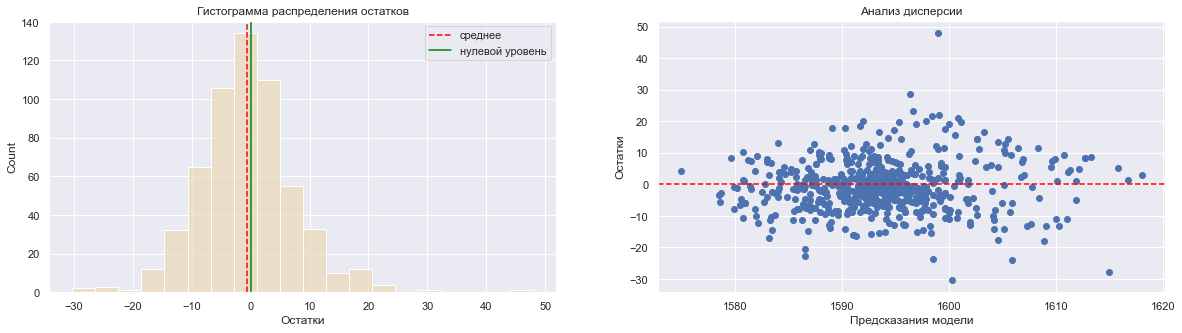

In [153]:
analyze_residuals(y_test - predicted_temps, predicted_temps)

In [154]:
(y_test - predicted_temps).mean().round(2)

-0.62

- Модель немного завышает предсказания
- Остатки тяготеют к нулевому уровню и распределены относительно равномерно, однак в диапазоне до 1580 градусов модель немного завышает предсказания, в диапазоне от 1610 градусов преимущественно занижает

# Анализ признаков

In [155]:
X = pd.DataFrame(df[fields], columns=fields)

In [156]:
explainer = shap.TreeExplainer(regressor_rf_v1.best_estimator_.named_steps['models'], X)
shap_values = explainer(X)

100%|===================| 2322/2324 [01:18<00:00]        

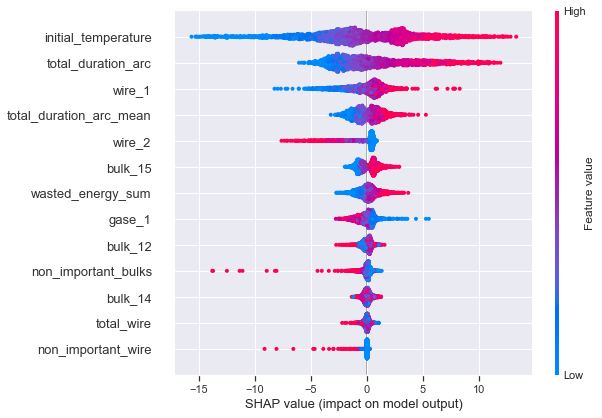

In [157]:
shap.plots.beeswarm(shap_values, max_display=16)

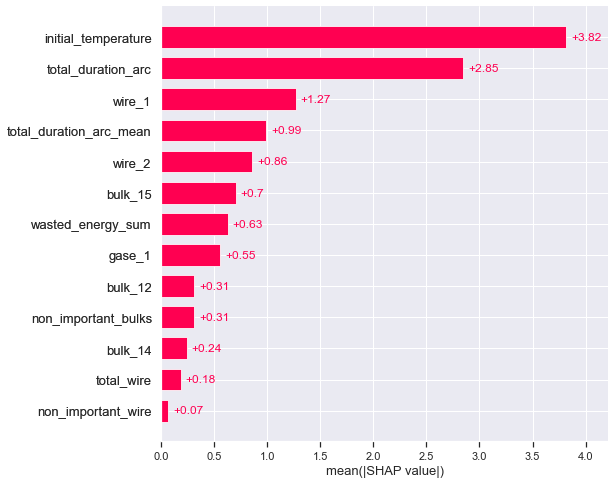

In [158]:
shap.plots.bar(shap_values, max_display=16)

- Чем больше начальная температура, тем больше модель склонна повысить прогнозируемую температуру
- Также на повышение температуры сильно влияет суммарное время нагрева
- wire_1 связана с повышением предсказанной температуры
- wire_2 же наоборот связана с понижением предсказанной температуры


- В общем случае самыми важными признаками модель считает начальную температуру, суммарную длительность нагрева, среднюю длительность одной итерации нагрева, отдельно bulk_15, wire_1 и wire_2.
- Меньше всего на предсказания повлияли признаки total_wire и bulk_14

# Вывод

- В ходе выполнения проекта была проделана работа с 7 датасетами
- В данных было достаточно много пропусков, но все они были обработаны до раздела с обучением моделей
- В рамках разведочного анализа данных (EDA) был проведён детальный анализ всех столбцов датасетов. На основе исходных данных были созданы новые признаки, включая:
    - Полную мощность (агрегированный показатель энергопотребления),
    - Коэффициент мощности (эффективность использования энергии),
    - Длительность нагрева (время, затраченное на нагрев стали),
    - Количество итераций нагрева (число циклов нагрева),
    - Суммарное время добавления примесей и средний интервал между добавлениями,
    - Общее количество примесей двух типов.


- Для повышения качества данных выполнена фильтрация выбросов:
    - Отсечение аномалий на основе квантильного анализа и визуальной оценки распределений,
    - Коррекция целевой переменной (температура плавления стали) — удалены значения, выходящие за заданный техзаданием диапазон.

Исследование показало, что:

- В каждой партии использовалась как минимум одна примесь (отсутствуют записи без добавок),
- Определены наиболее частые и редкие типы добавок,
- Редкие примеси объединены в один обобщённый признак для упрощения модели.
- Далее все данные были объединены в один датасет, агрегированный по партиям


- В ходе корреляционного анализа
    - Была проверена phik корреляция между признаками в объединенном датасете
    - Получены наборы признаков, имеющие наибольшее влияние на таргет переменную
    - Проведена проверка на мультиколлинеарность
 
- Далее было выполнено обучение ряда моделей: дерево решений, линейная и гребневая регрессия, а также градиентный бустинг и случайный лес
    - Лучшей на кросс-валидации себя показала модель случайного леса
    - Далее она была протестирована на тестовой выборке. Метрика MAE=6.055, что соответствует требованиям проекта
    - Был вычислен  $𝑅^2$, который показал, что модель является приемлемой, но есть к чему стремиться
- В ходе изучения остатков модели было замечено, что гребневая регрессия немного занижает предсказания
- Остатки тяготеют к нулевому уровню и распределены относительно равномерно, однак в диапазоне до 1580 градусов модель немного завышает предсказания, в диапазоне от 1610 градусов преимущественно занижает

Далее был проведен SHAP анализ признаков:

- Чем больше начальная температура, тем больше модель склонна повысить прогнозируемую температуру
- Также на повышение температуры сильно влияет суммарное время нагрева
- wire_1 связана с повышением предсказанной температуры
- wire_2 же наоборот связана с понижением предсказанной температуры


- В общем случае самыми важными признаками модель считает начальную температуру, суммарную длительность нагрева, среднюю длительность одной итерации нагрева, отдельно bulk_15, wire_1 и wire_2.
- Меньше всего на предсказания повлияли признаки total_wire и bulk_14


**Рекомендация**

- Для наибольшей точности модели требуются качественные измерения температуры сплава. Модель тяготеет к историческим данным, поэтому, возможно, следует смотреть в сторону моделирования процесса как временного ряда
- Внимательно смотреть за примесями. Некоторые из них имеют огромное влияние на температуру, особенно на wire_1 и wire_2, а также bulk_15